## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:3'

desired_range = [750,850]
desired_channels = 25

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


## Go from nograting cube to grating cube with grad descent


In [3]:
def WienerDeconvolution(final, kernel, lamb = 0.001):
    
    nc = kernel.shape[-1]
    padder = [[0,0]]*(len(kernel.shape) -1) + [[nc//2,nc//2]]
    
    # kernel = np.fft.fftshift(kernel)

    
    kernelpad = np.pad(kernel,padder)
    finalpad = np.pad(final,padder)
    
    kernel_fft = np.fft.fft(kernelpad,axis=-1)
    final_fft = np.fft.fft(finalpad,axis=-1)

    original_fft=(np.conj(kernel_fft)*final_fft)/ (np.square(np.abs(kernel_fft))+ lamb)


    original = np.abs(np.fft.ifftshift(np.fft.ifft(original_fft,axis=-1),axes=-1))

    original = original[...,nc//2:-(nc//2)]

    return original

dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20231016_Monochromator/'


In [4]:

grating_cube = torch.load(dir + 'pinhole_cube_grating.pt').to(torch.float32).to(device)

nograting_cube = torch.load(dir + 'pinhole_cube_nograting.pt').to(torch.float32).to(device)



norm = nograting_cube.max()

grating_cube = grating_cube / norm
nograting_cube = nograting_cube / norm

lines_grating_cube = torch.load(dir + 'lines_cube_grating.pt').to(torch.float32).to(device)
lines_nograting_cube = torch.load(dir + 'lines_cube_nograting.pt').to(torch.float32).to(device)

norm = lines_nograting_cube.max()
lines_grating_cube = lines_grating_cube / norm
lines_nograting_cube = lines_nograting_cube / norm


mask_grating_cube = torch.load(dir + 'mask_cube_grating.pt').to(torch.float32).to(device)
mask_nograting_cube = torch.load(dir + 'mask_cube_nograting.pt').to(torch.float32).to(device)

norm = mask_nograting_cube.max()
mask_grating_cube = mask_grating_cube / norm
mask_nograting_cube = mask_nograting_cube / norm

# ratio = grating_cube.mean() / nograting_cube.mean()


#i initialize kernel with the wiener deconvolution.
simnograting_cube = torch.zeros_like(nograting_cube)
maxloc = torch.where(nograting_cube==nograting_cube.max())
simnograting_cube[:,:,maxloc[2],maxloc[3]] = 1
# print(ratio)
kernel = disperser.undisperse_all_orders(grating_cube, simnograting_cube, wiener=True, lamb=0.0001).to(device).to(torch.float32)

kernel[kernel<kernel.max()*0.001] = 0



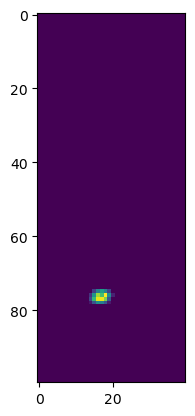

In [5]:
plt.imshow(torch.abs( grating_cube)[0,0,380:480,1200:1240].cpu().detach().numpy())

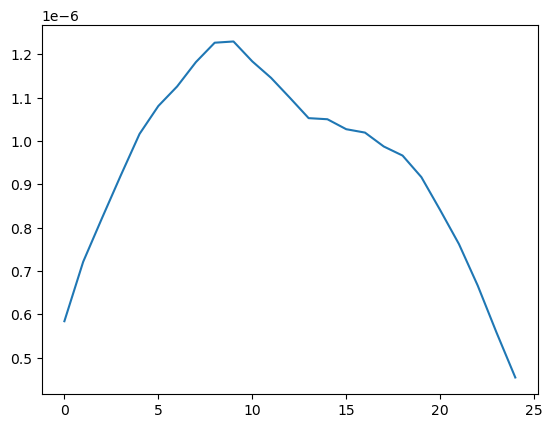

In [6]:
plt.plot(nograting_cube.mean(dim=(0,2,3)).cpu())

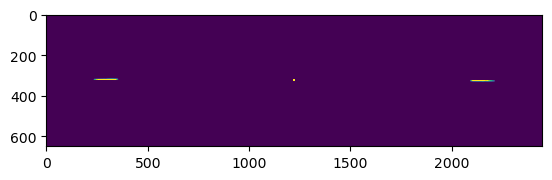

In [7]:
plt.imshow(kernel.sum(dim=(0,1)).cpu(),vmax=0.01)

### Find a multiplication factor between them?

In [8]:
cluster_points = 3

# pos = findclusters(grating_cube.cpu(),threshold=0.2, padding=100,type='boxes', cluster_points = cluster_points)


pos = torch.tensor([[[275,575],[150,500]],[[275,575],[1100,1300]],[[275,575],[2000,2300]]])

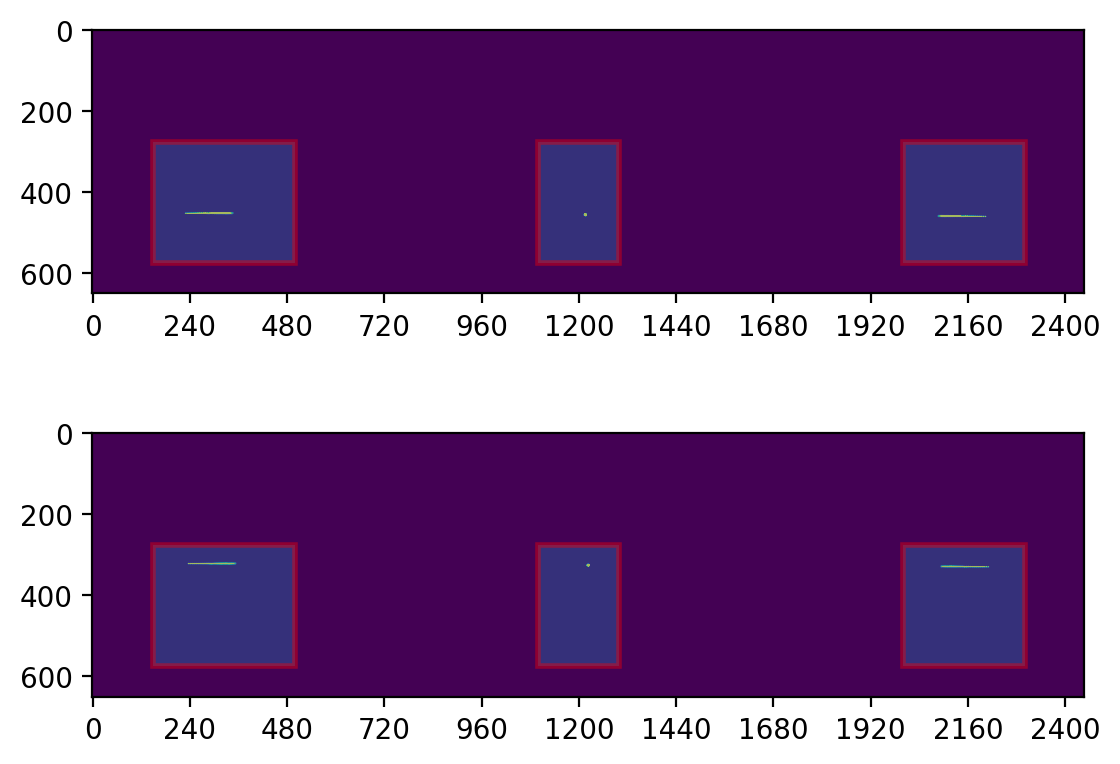

In [9]:
fig,ax = plt.subplots(2,1,dpi=200)
ax[0].imshow(torch.sum((grating_cube)[0],dim=0).cpu().detach().numpy(),vmax=0.01)
ax[1].imshow(torch.sum((kernel)[0],dim=0).cpu().detach().numpy(),vmax=0.01)

ax[0].set_xticks(np.linspace(0,2400,11));
ax[1].set_xticks(np.linspace(0,2400,11));

import matplotlib.patches as patch

for i in range(cluster_points):
    ax[0].add_patch(patch.Rectangle([pos[i,1,0],pos[i,0,0]],pos[i,1,1] - pos[i,1,0],pos[i,0,1] - pos[i,0,0], facecolor=None, ec='r',alpha=0.4, lw=2))
    ax[1].add_patch(patch.Rectangle([pos[i,1,0],pos[i,0,0]],pos[i,1,1] - pos[i,1,0],pos[i,0,1] - pos[i,0,0], facecolor=None, ec='r',alpha=0.4, lw=2))



In [9]:
grating_cube.mean(), nograting_cube.mean()

(tensor(9.4549e-07, device='cuda:3'), tensor(9.4549e-07, device='cuda:3'))

In [10]:
scaled_kernel = kernel.clone()


init_guess = fwd.disperser.disperse_all_orders(nograting_cube,kernel )

for i in range(cluster_points):
    fac = grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3)) / init_guess[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3))

    scaled_kernel[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]] = scaled_kernel[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]] * fac[None,:,None,None]


In [12]:
from models.custom.modules import CenterOfMassLoss

In [13]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,scaled_kernel) 

for i in range(cluster_points):
    print(i)
    
    loss_fn2 = CenterOfMassLoss(pos[i:i+1], intensity_factor= 3, funda_weight=1, channels=desired_channels, funda_index=1) 
    print(loss_fn2(grating_cube,init_guess))


epochs =200

model = AffineTransformModel(region = pos, rot=0., transX=0., transY=0.,scale=True, no_channels=desired_channels).to(device)

loss_fn1 = torch.nn.MSELoss()
loss_fn2 = CenterOfMassLoss(pos, intensity_factor= 3, funda_weight=1, channels=3) 


loss = loss_fn1(init_guess,grating_cube) + loss_fn2(init_guess,grating_cube)  * 1e-5
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)




torch.cuda.empty_cache()


0
tensor(0.7859, device='cuda:3')
1
tensor(3.6101, device='cuda:3')
2
tensor(0.8367, device='cuda:3')


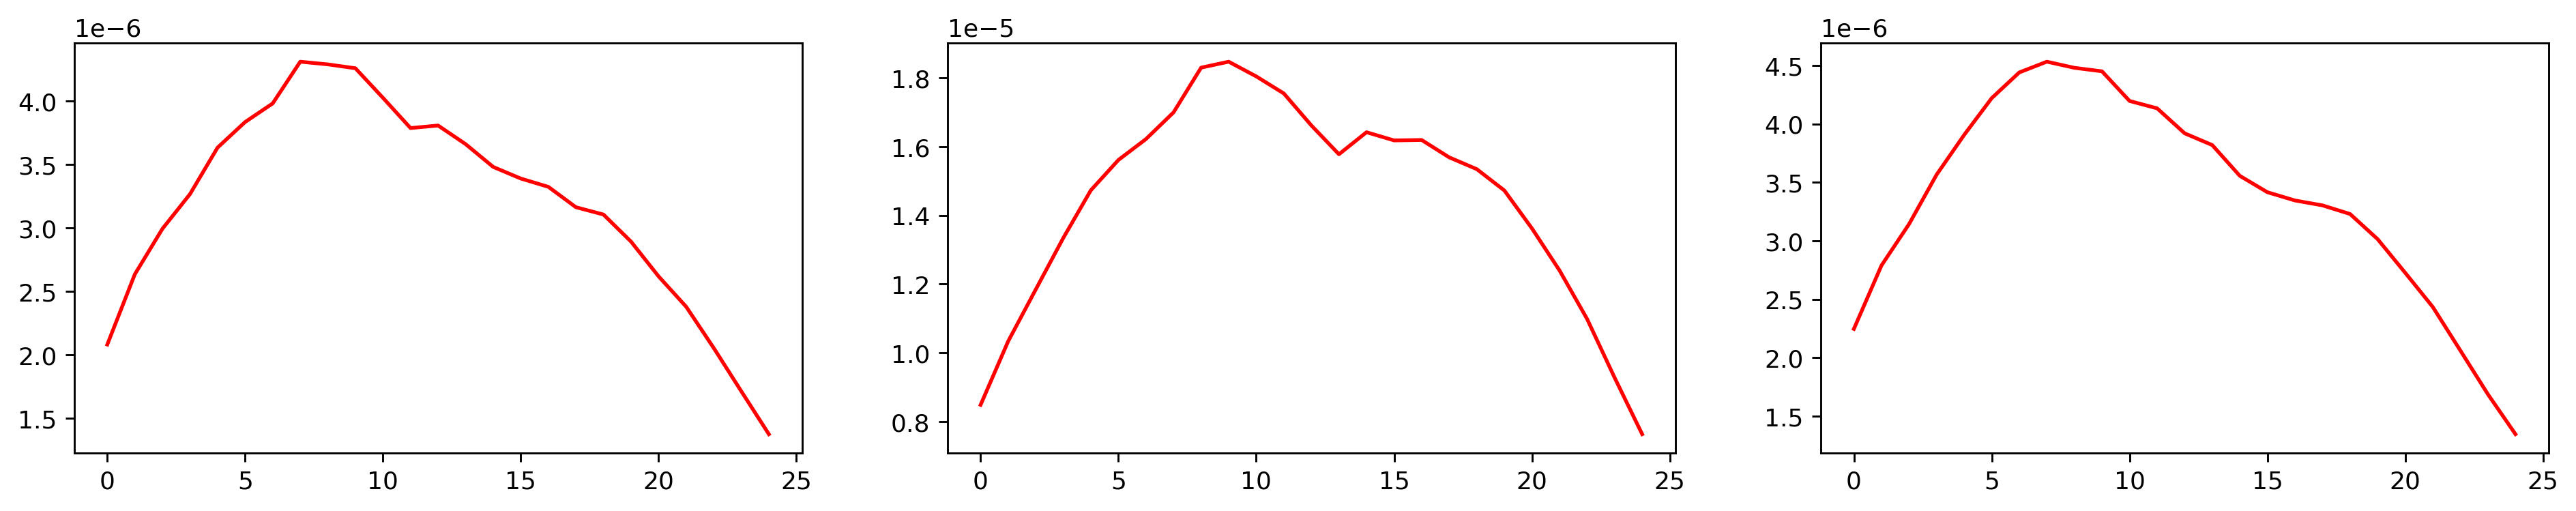

In [14]:
fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(kernel[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    # print(kernel[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T)


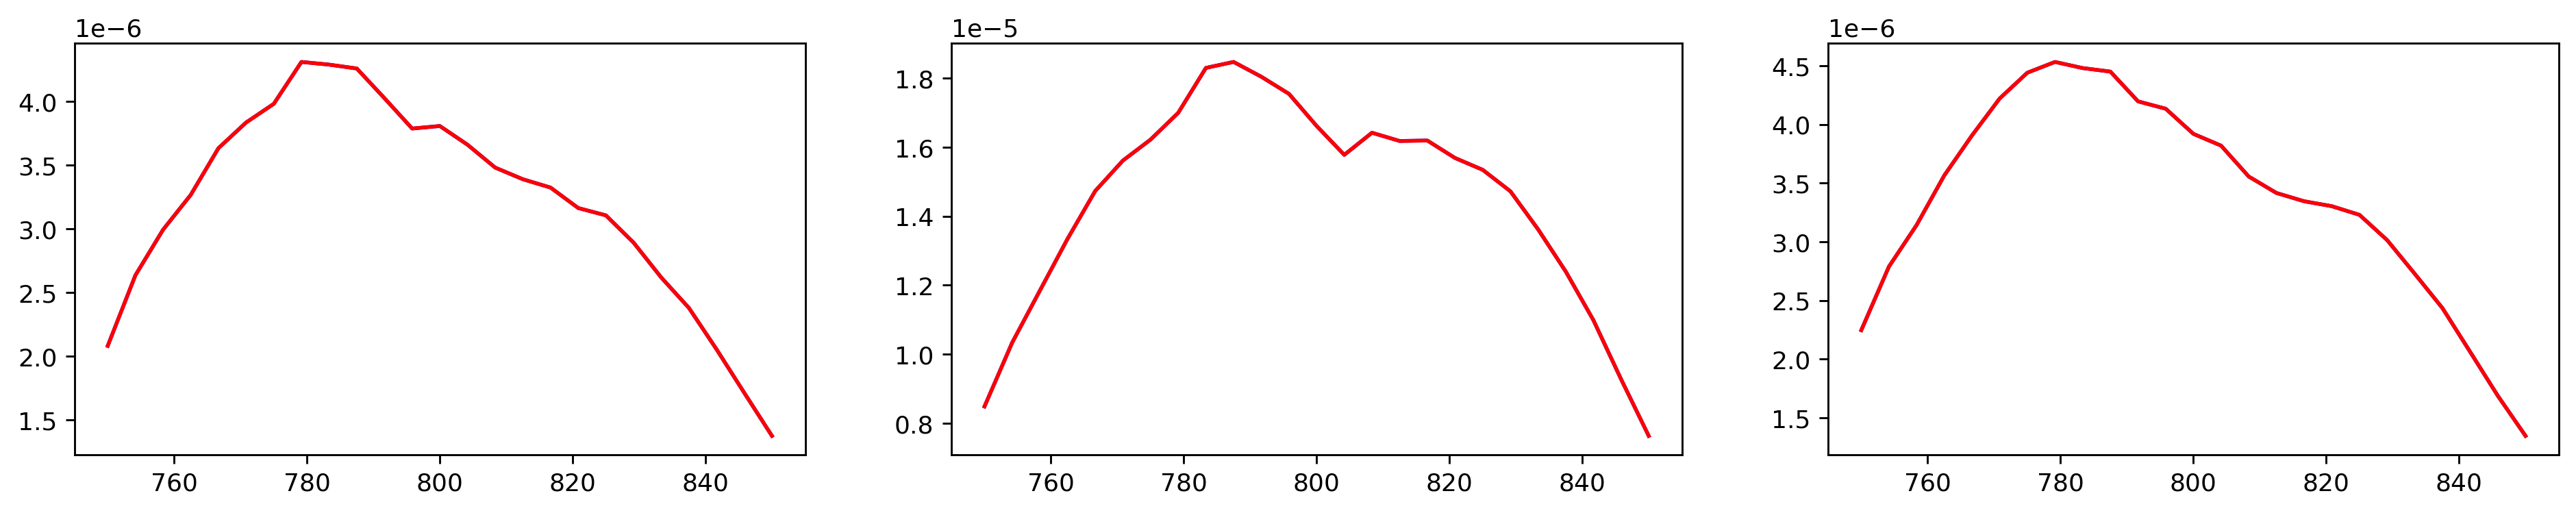

In [15]:
yhat_init = fwd.disperser.disperse_all_orders(nograting_cube,scaled_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'b');
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),yhat_init[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');

In [16]:
model.fit_angles(truth = grating_cube, init_guess=init_guess, funda_idx = cluster_points//2)
affine_kernel = model(scaled_kernel)
    
yhat_rot = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)


In [17]:
model.fit_translation(truth = grating_cube, init_guess=yhat_rot, intensity_factor = 2)

affine_kernel = model(scaled_kernel)    
yhat_rot_trans = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

In [18]:
store2 = torch.zeros((cluster_points,2,2))

for i in range(cluster_points):
    diff = []

    for l in range(3):
        guess = loss_fn2.calculate_center_of_mass(yhat_rot_trans[:,l],region = pos[i])
        true = loss_fn2.calculate_center_of_mass(grating_cube[:,l],region = pos[i])

        diff.append(true - guess)

    diff = torch.stack(diff)

    store2[i,0] = torch.mean(diff,dim=0)
    store2[i,1] = torch.std(diff,dim=0)
    

In [19]:
store2

tensor([[[0.8916, 0.1922],
         [0.1299, 0.0123]],

        [[0.3547, 0.2024],
         [0.0904, 0.0129]],

        [[0.6111, 0.1787],
         [0.1054, 0.0131]]], grad_fn=<CopySlices>)

In [20]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 100

In [21]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []



start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    affine_kernel = model(scaled_kernel)
    
    yhat = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

    mse = loss_fn1(yhat, grating_cube)
    
    loss =  mse + loss_fn2(yhat, grating_cube[:,:]) * 1e-5
    # loss =  loss_fn2(yhat, grating_cube)  

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() * grating_cube.size(0)
    train_mse        = mse.data.item() * grating_cube.size(0)





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, train mse: {(train_mse/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)
    history['mse'].append(train_mse)


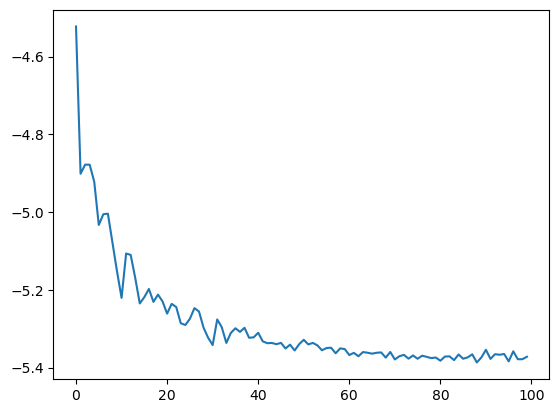

In [22]:
plt.plot(np.log10(history['loss']))


In [23]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,kernel)

affine_kernel = model(scaled_kernel)
yhat = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)


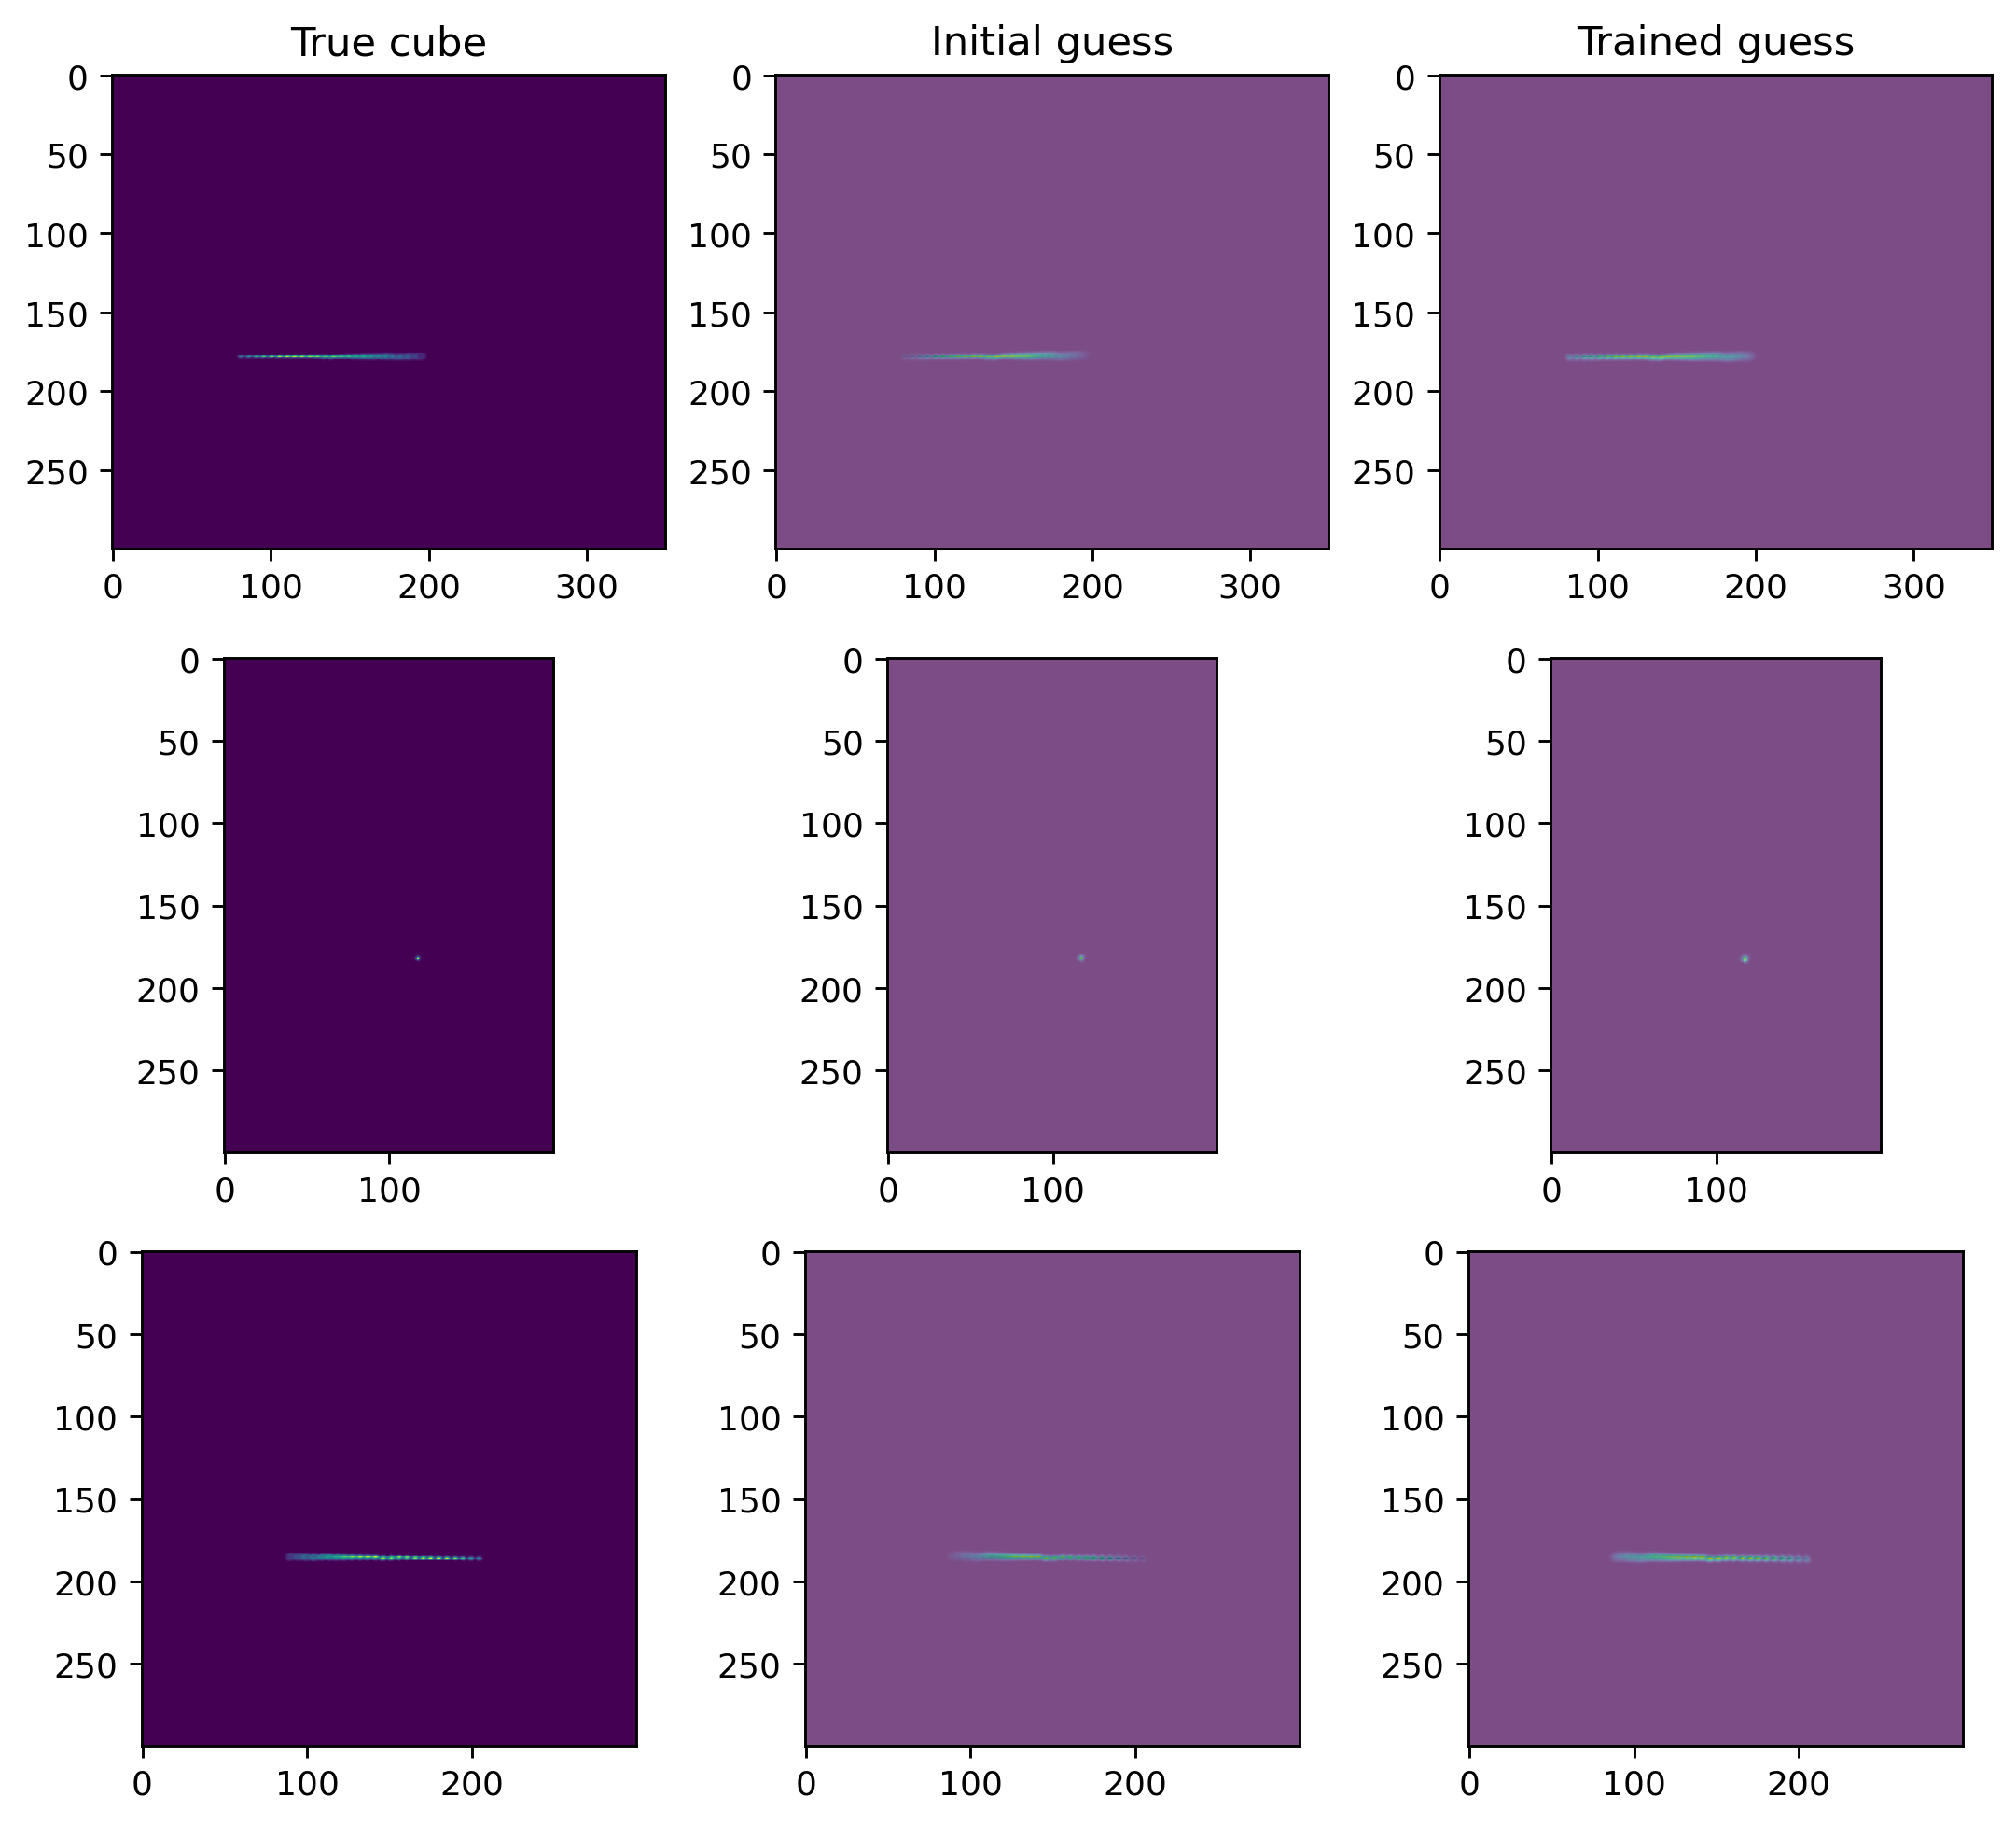

In [24]:
plot_orders = [0,1,2]

fig,ax = plt.subplots(len(plot_orders),3,figsize=(10,9),dpi=260)

for n,i in enumerate(plot_orders):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]#[200,400]
    
    vmax,vmin = torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).max(), torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).min()


    ax[n,0].imshow(torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
    ax[n,1].imshow(torch.sum(init_guess[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Initial guess')
    ax[n,1].imshow(torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.3)
    ax[n,2].imshow(torch.sum(yhat[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,2].set_title('Trained guess')
    ax[n,2].imshow(torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.3)




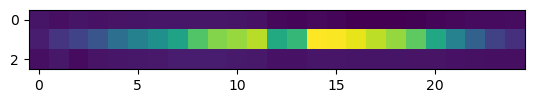

In [25]:
plt.imshow(model.grating_spectrum.cpu().detach())

tensor(2.0389e-09) tensor(0.)
tensor(1.7907e-10) tensor(0.)


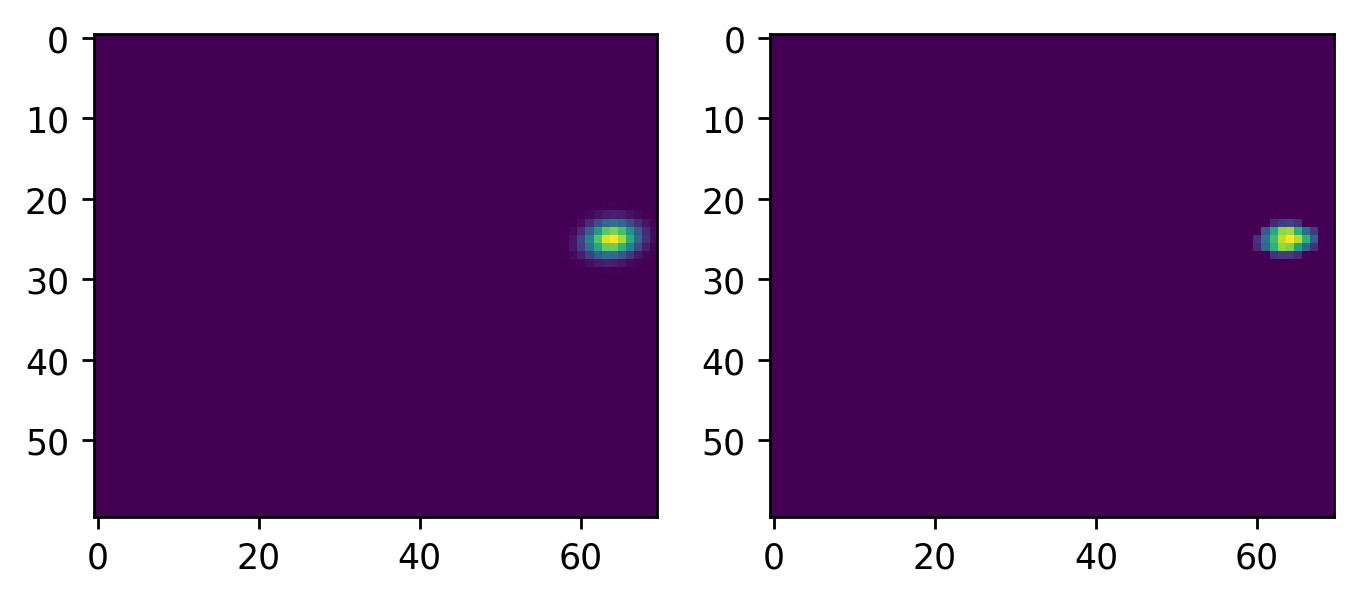

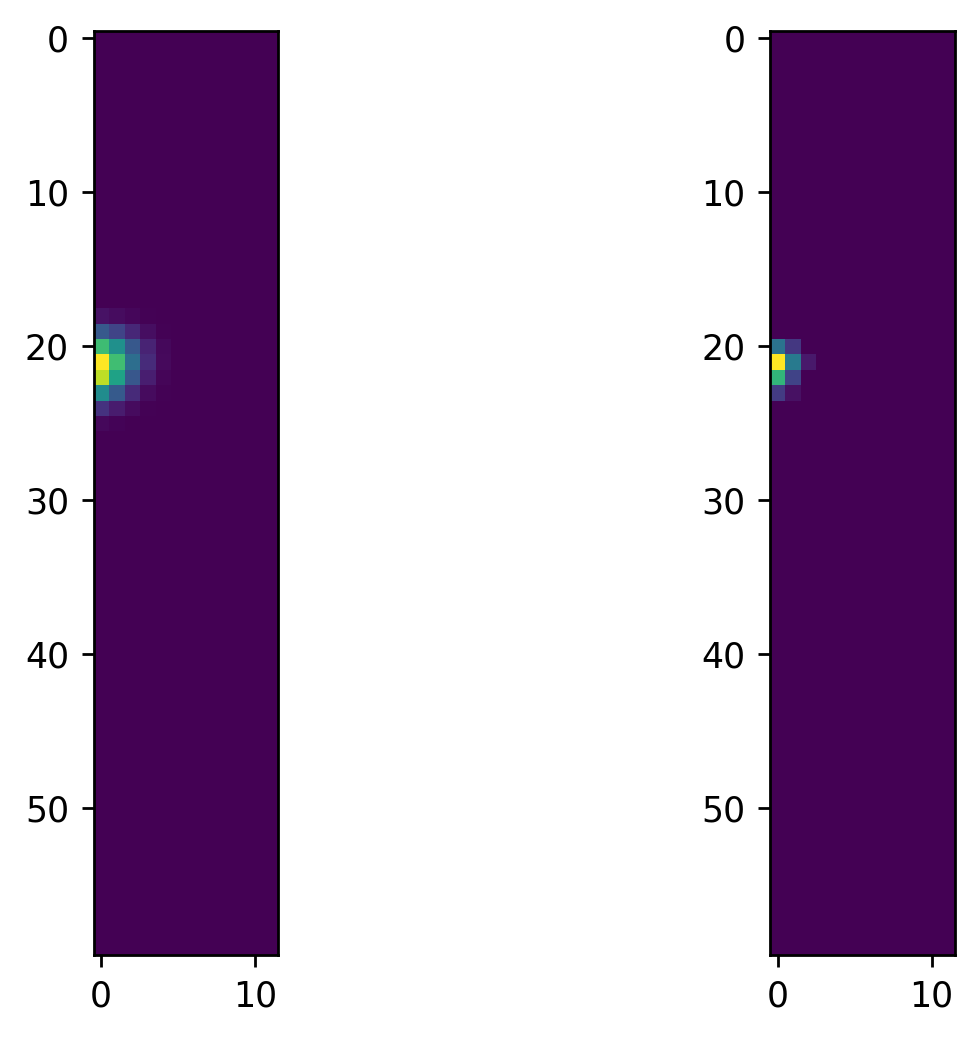

In [26]:
fig,ax = plt.subplots(1,2,dpi=250)
ax[0].imshow(yhat[0,5,435:495,2050:2120].cpu().detach().numpy())
ax[1].imshow(grating_cube[0,5,435:495,2050:2120].cpu().detach().numpy())

print(yhat[0,0,398:425,2090:2120].cpu().detach().sum() , grating_cube[0,0,398:425,2090:2120].cpu().detach().sum())

fig,ax = plt.subplots(1,2,dpi=250)
ax[0].imshow(yhat[0,1,435:495,1218:1230].cpu().detach().numpy())
ax[1].imshow(grating_cube[0,1,435:495,1218:1230].cpu().detach().numpy())

print(yhat[0,1,398:408,1218:1230].cpu().detach().sum() , grating_cube[0,1,398:408,1218:1230].cpu().detach().sum())

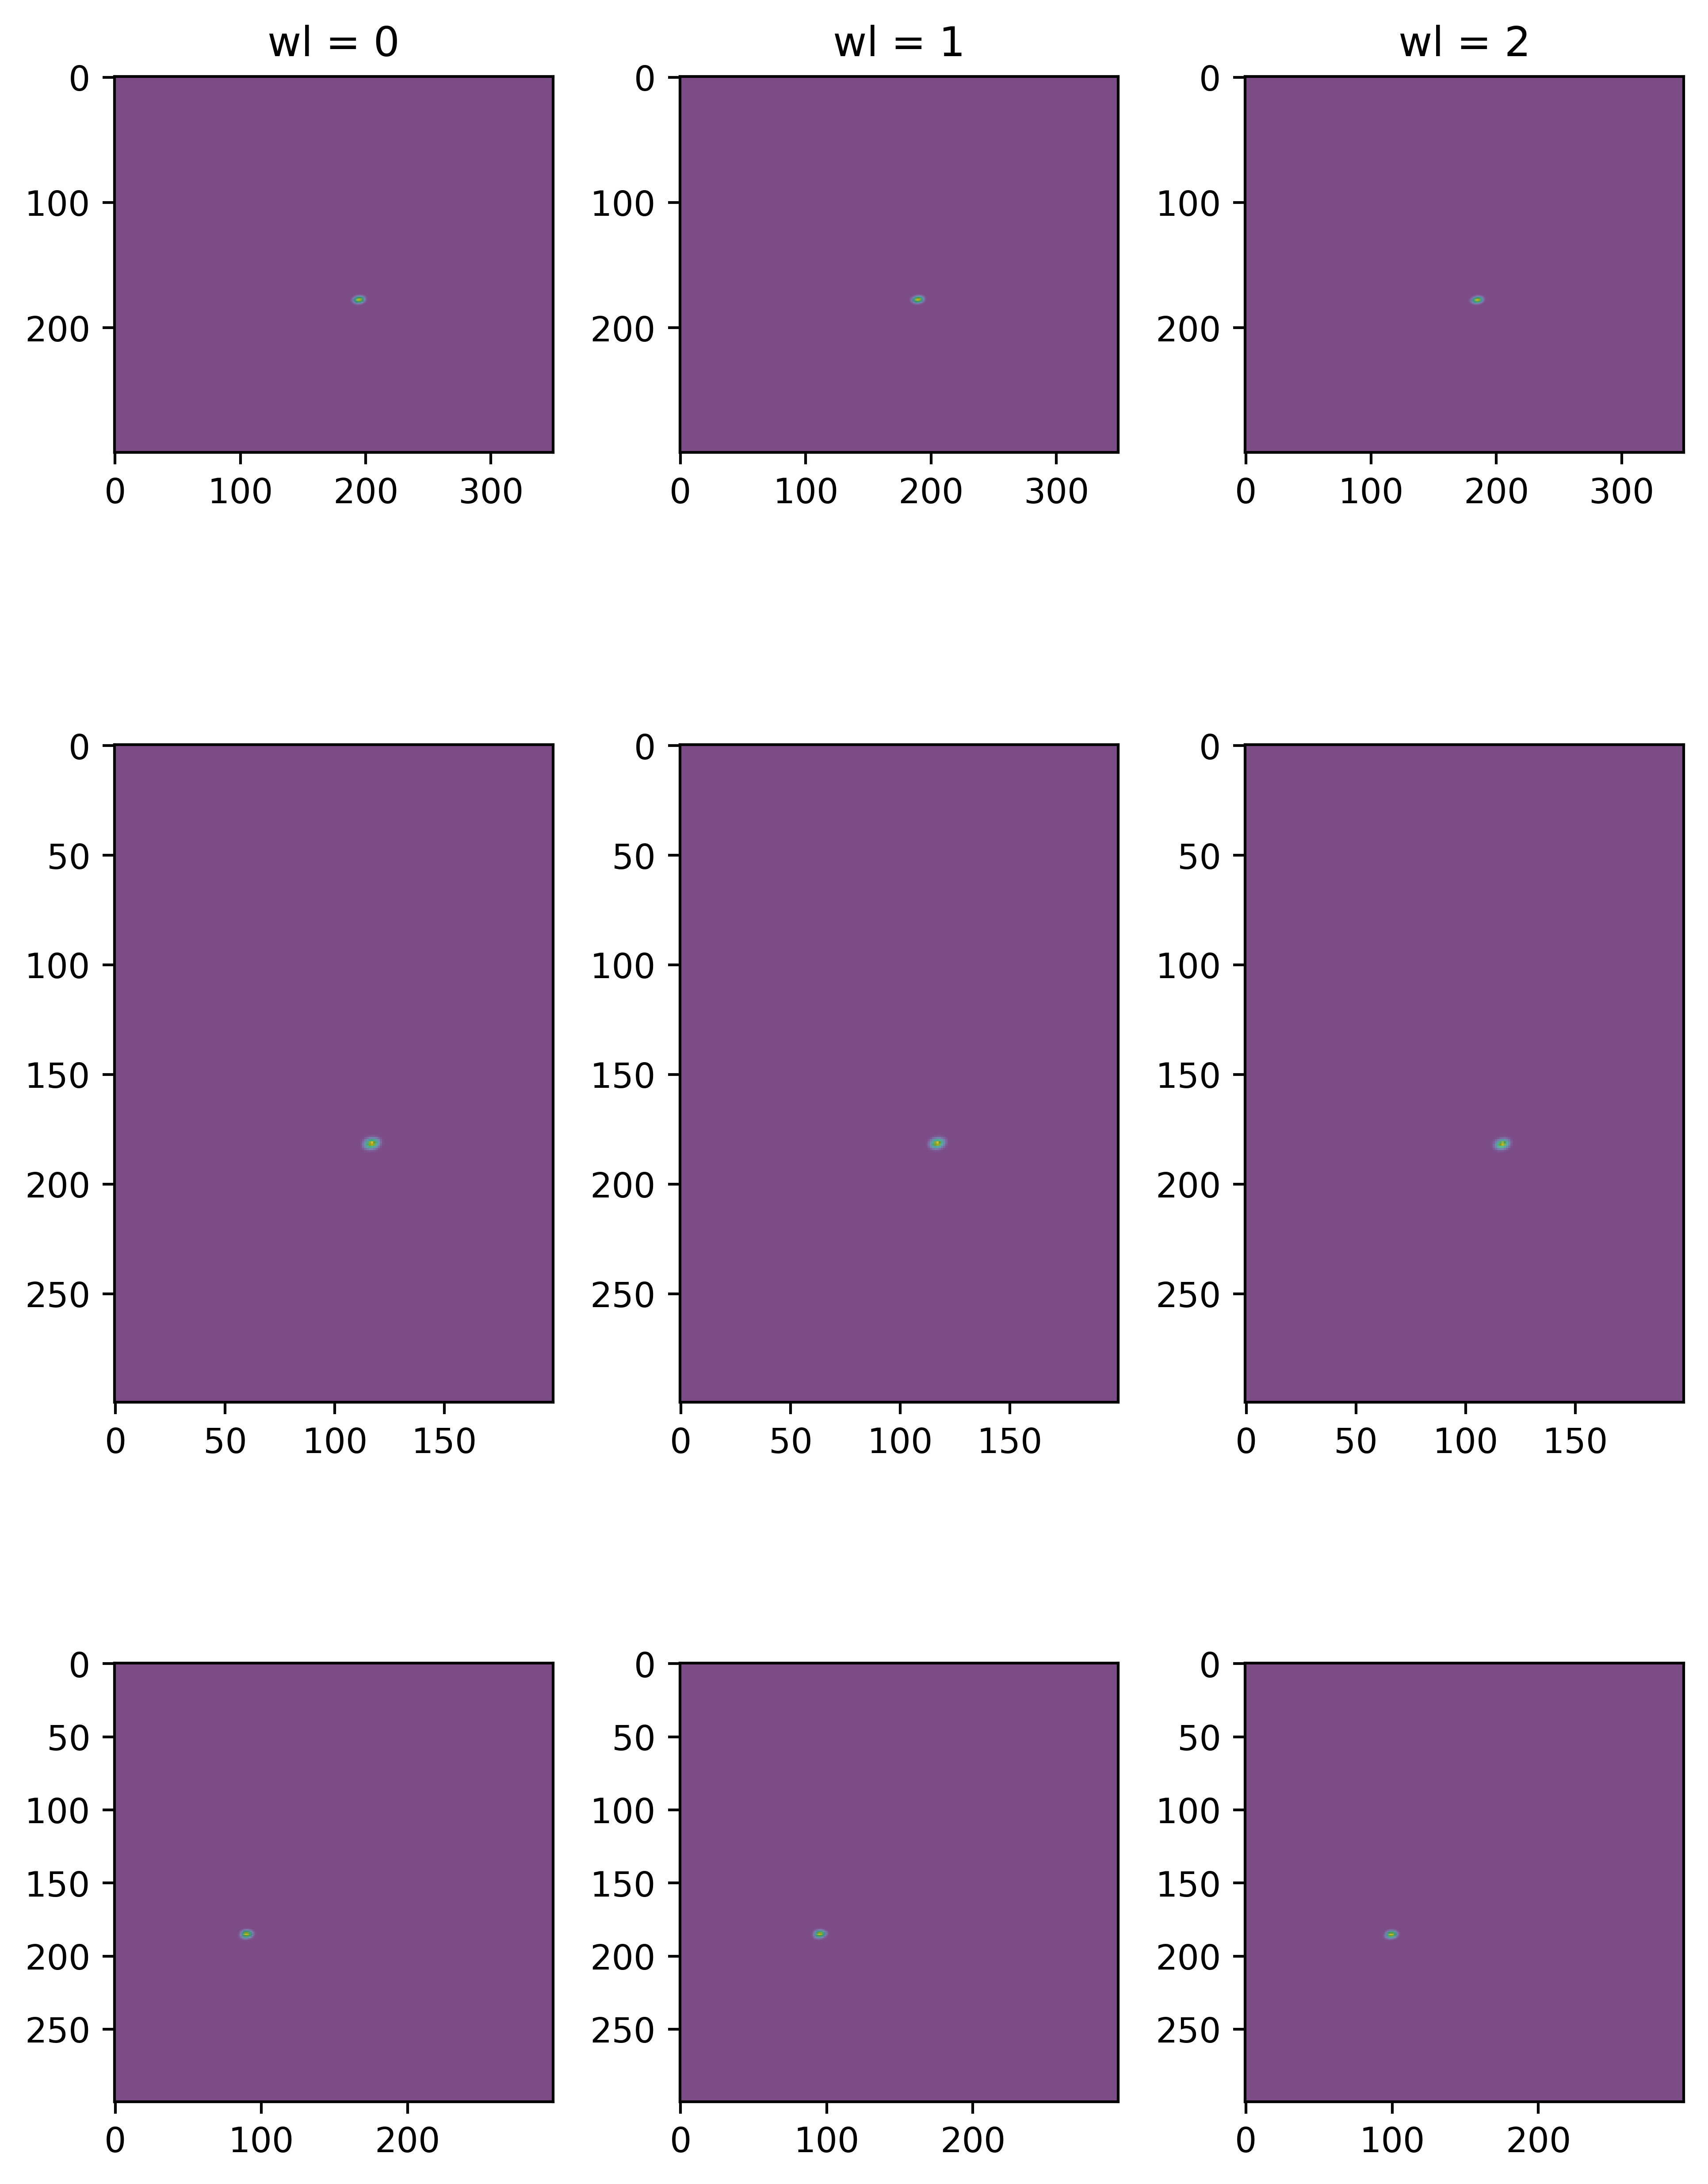

In [27]:
wls = [0,1,2]


fig,ax = plt.subplots(cluster_points,3,figsize=(7,10),dpi=560)

for j in range(len(wls)):
    ax[0,j].set_title(f'wl = {wls[j]}')

for i in range(len(pos)):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]
    for j in range(len(wls)):# com = loss_fn2.calculate_center_of_mass(grating_cube[:,wls[j]],pos[i]).cpu().detach().numpy()
        # ax[i,j].plot(com[0][1],com[0][0],'r.',markersize=0.2)
        ax[i,j].imshow(yhat[0,wls[j],b1:b2,b3:b4].cpu().detach().numpy())
        ax[i,j].imshow(grating_cube[0,wls[j],b1:b2,b3:b4].cpu().detach().numpy(),cmap='Greys',alpha=0.3)

fig.tight_layout()

In [28]:
# plt.plot(model.grating_spectrum.detach().cpu().T);

In [29]:
yhat_affine = yhat.clone()

In [30]:
torch.save(affine_kernel, '../affine_kernel.pt')

## Here i am gunna train in a different way

There will be three steps to training: 1) train kernel on pinhole; 2) train CG to remove field distortion 3) train kernel on mask

In [9]:
affine_kernel = torch.load('../affine_kernel.pt',map_location=device).requires_grad_(False)


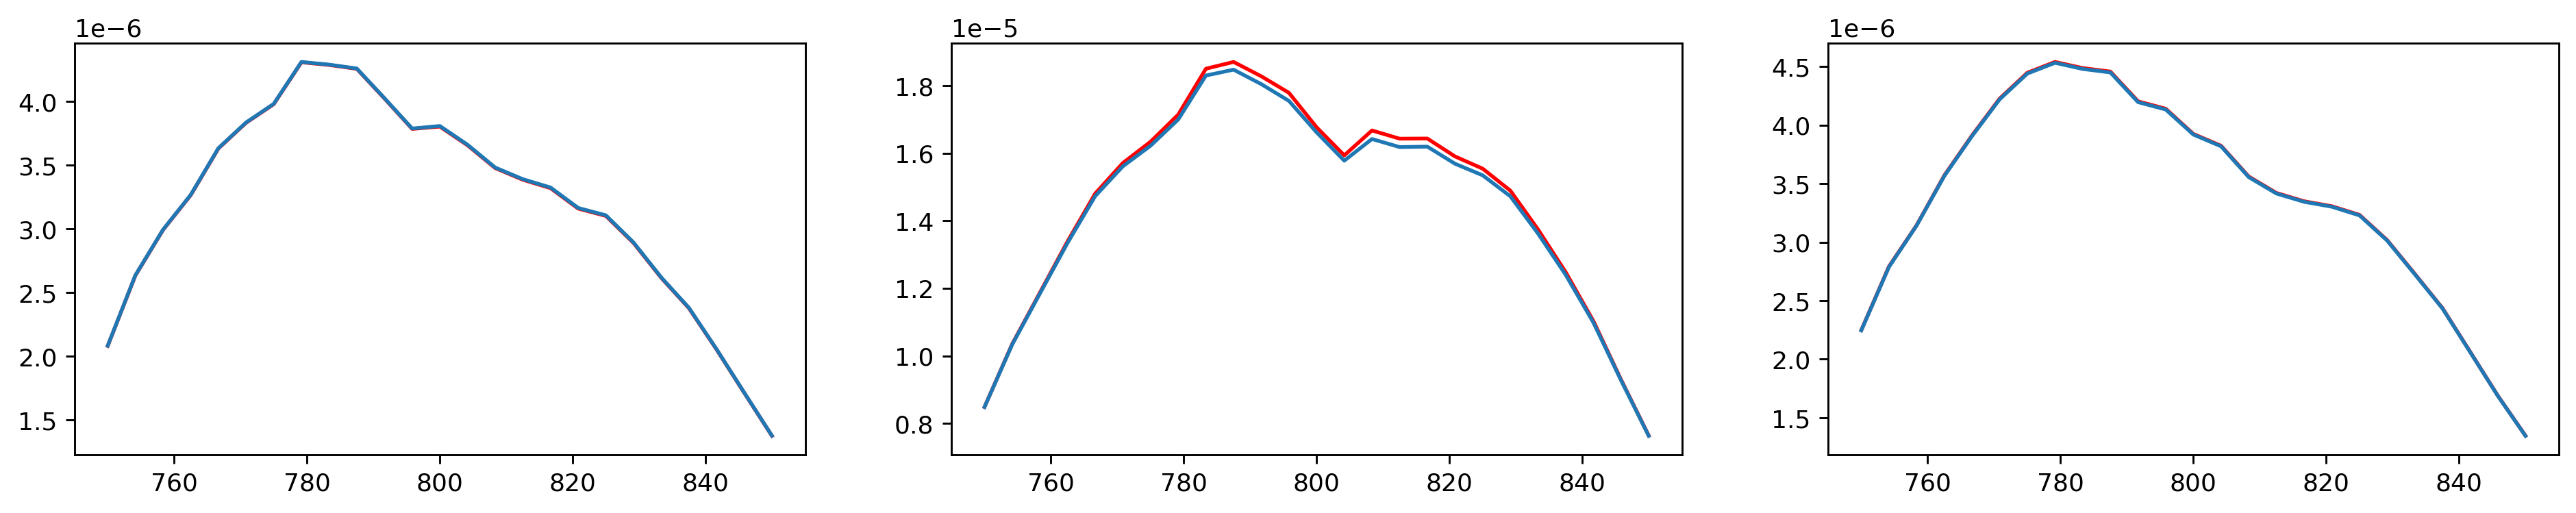

In [10]:
yhat_affine = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),yhat_affine[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);

In [11]:
yhat_affine = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

In [12]:
padding = 4


kernel_learner_model = KernelLearner(kernel=affine_kernel.clone(), padding=padding).to(device) 

kernelsize=5
CG_channels = 15
initialiser = torch.ones((1,CG_channels,mask_grating_cube.shape[2],mask_grating_cube.shape[3]))
initialiser = initialiser / 15
distortion_remover = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_grating_cube.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=False).to(device) 
CG_conv_list = torch.nn.ModuleList([CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = mask_grating_cube.shape[2:],CG_type='map',initialiser = initialiser, regulariser=None, locally_connected=False).to(device) for i in range(mask_grating_cube.shape[1])])

lr = 4e-3
epochs = 3000

params = list(distortion_remover.parameters()) + list(kernel_learner_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr)

init_guess = kernel_learner_model(mask_nograting_cube)

loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,mask_grating_cube)
print(loss)

tensor(3.9457e-05, device='cuda:3', grad_fn=<MseLossBackward0>)


In [16]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []

lr = 2e-3
epochs = 3000

params = list(CG_conv_list.parameters()) + list(kernel_learner_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr)



start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    kernel_learner_model.train()
    CG_conv_list.train()
    num_train_examples = 1

    # optimizer.zero_grad()
    # yhat = kernel_learner_model(nograting_cube)
    # loss1 = loss_fn(yhat, grating_cube)
    # loss1.backward()
    # optimizer.step()

    optimizer.zero_grad()
    initial = kernel_learner_model(mask_nograting_cube)


    all_results = []
    all_reg = []
    for i in range(mask_grating_cube.shape[1]):
        n = i//2 * 2
        all_results.append(CG_conv_list[n](initial[:,i:i+1]))
        all_reg.append(hessian(torch.nn.functional.relu(CG_conv_list[n].CG.map), boundaries = [800,1700]))

    reg = torch.mean(torch.stack(all_reg))
    yhat = torch.concat(all_results,dim=1)
    # yhat = torch.concat([distortion_remover(initial[:,i:i+1]) for i in range(mask_grating_cube.shape[1])],dim=1)
    # 

    # reg = hessian(torch.nn.functional.relu(distortion_remover.CG.map), boundaries = [800,1700])

    loss2 = loss_fn(yhat, mask_grating_cube) + reg * 1e-8
    loss2.backward()
    optimizer.step()

    for i in range(mask_grating_cube.shape[1]):
        CG_conv_list[i].conv.weight.data = torch.clamp(CG_conv_list[i].conv.weight.data,0,100)
    # distortion_remover.conv.weight.data = torch.clamp(distortion_remover.conv.weight.data,0,100)


    train_loss         = loss.data.item() * grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:,  mask loss: {loss2.data.item():5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(loss2.data.item())


    


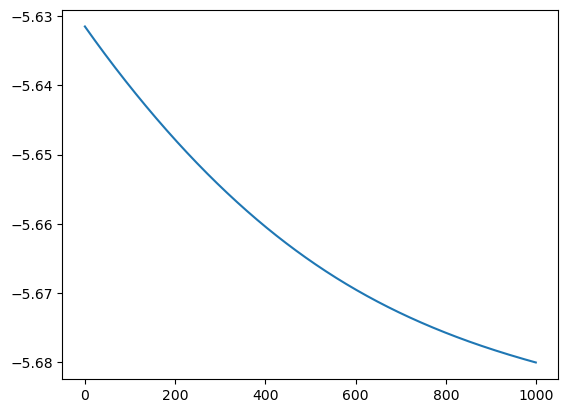

In [19]:
plt.plot(np.log10( history2['mse'][2000:]))

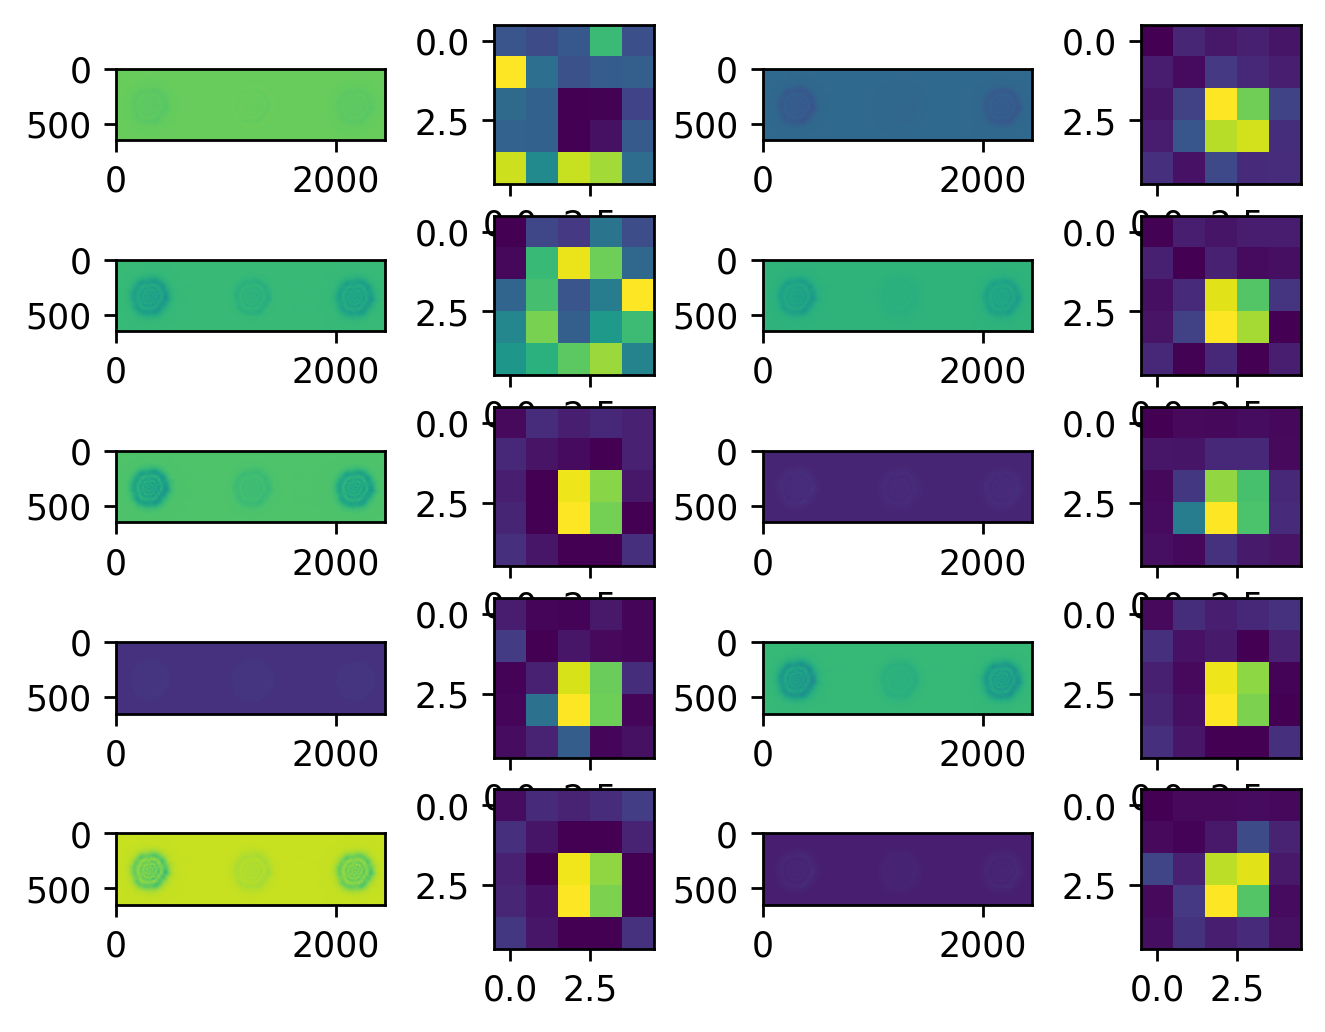

In [21]:
bla = [p for p in CG_conv_list[12].parameters()]

fig,ax = plt.subplots(5,4,dpi=250)

for i in range(5):
    ax[i,0].imshow(bla[2].cpu().detach()[0,i*2])
    ax[i,1].imshow(bla[0].cpu().detach()[i*2,0])
    ax[i,2].imshow(bla[2].cpu().detach()[0,i*2+1])
    ax[i,3].imshow(bla[0].cpu().detach()[i*2+1,0])


Text(0.5, 0, 'Epochs')

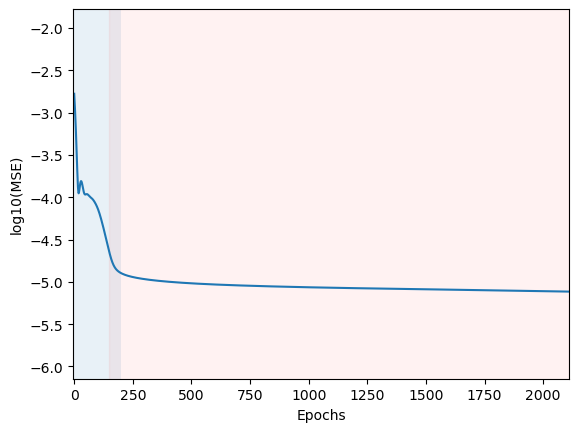

In [25]:

mina, maxa = np.log10(history2['mse']).min(), np.log10(history2['mse']).max()

plt.plot(np.log10(history2['mse']))
# plt.plot(np.log10(history['mse']+history2['mse']))
plt.fill_betweenx(np.linspace(-9,1,100),-1,200,alpha=0.1)
plt.fill_betweenx(np.linspace(-9,1,100),150,2109,color='r',alpha=0.05)

plt.xlim([-5,2110])
plt.ylim([mina-1,maxa+1])
plt.ylabel('log10(MSE)')
plt.xlabel('Epochs')

# first make a cg conv layer with approx the right params. 

This is to remove field curvature

In [7]:
loss_fn = torch.nn.MSELoss()

init_guess_pinhole = fwd.disperser.disperse_all_orders(mask_nograting_cube,trained_kernel).detach()
loss_fn(init_guess_pinhole,mask_grating_cube)

tensor(8.2774e-06, device='cuda:1')

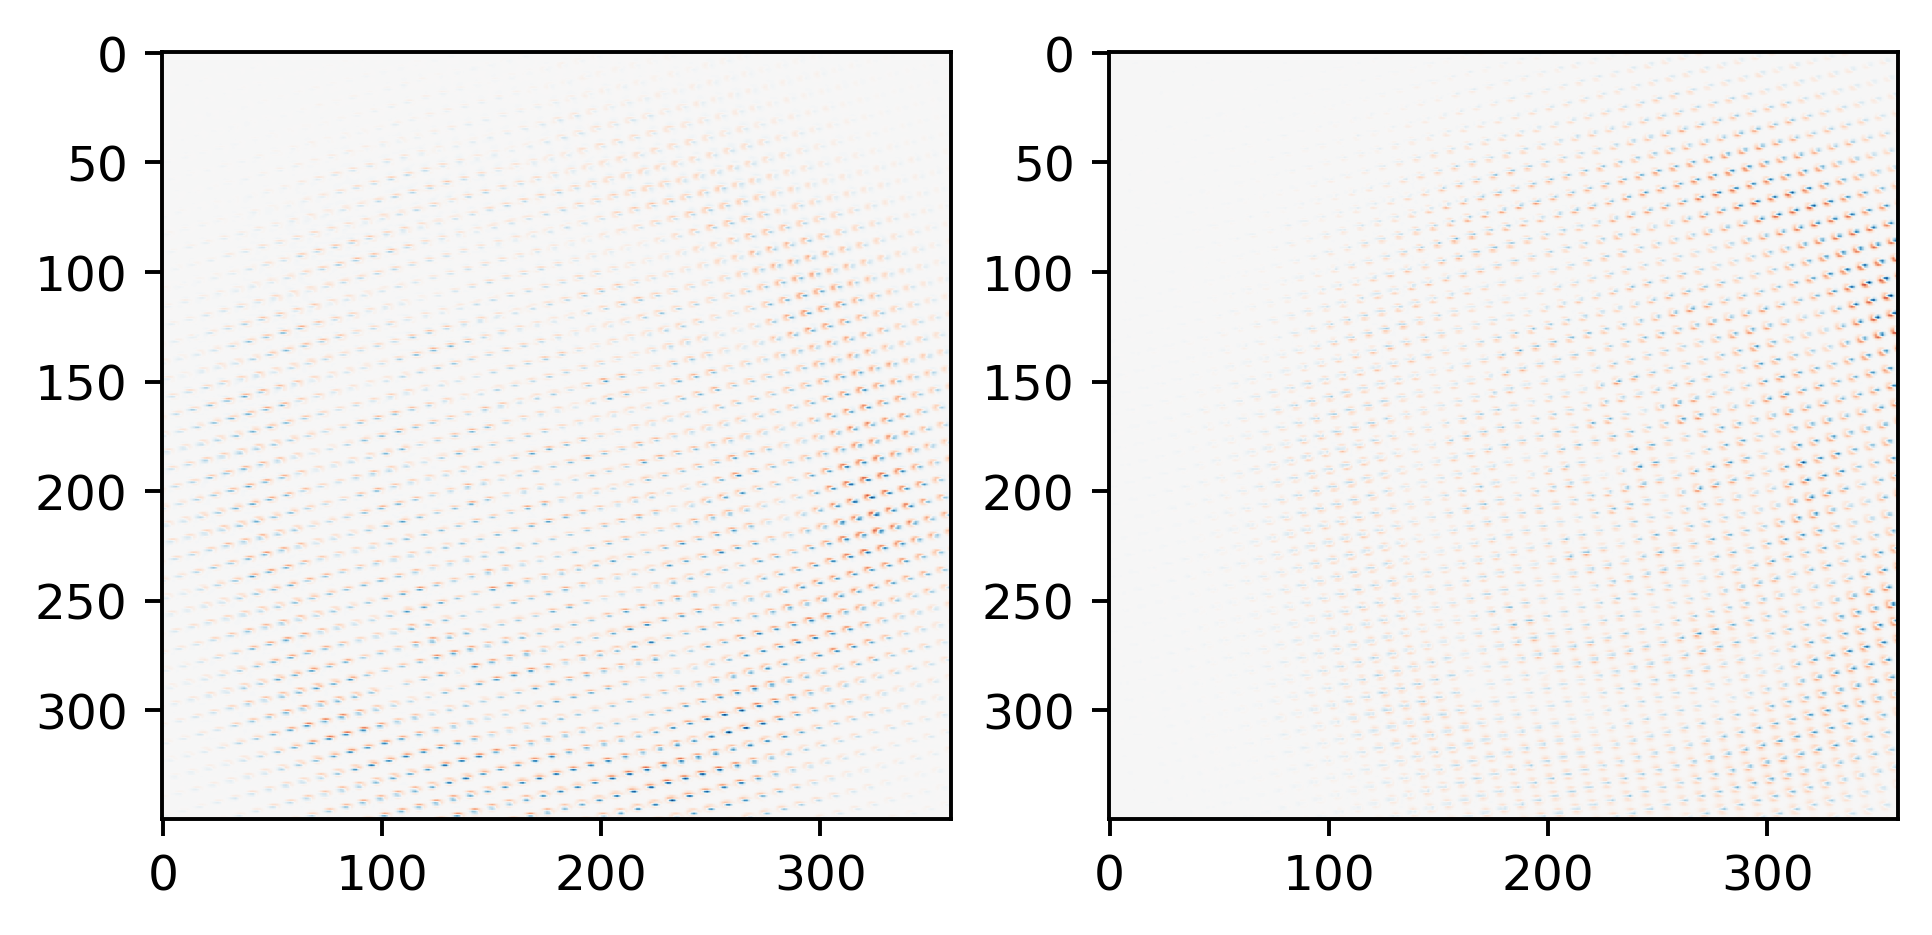

In [8]:
wl = 11

from scipy.ndimage import gaussian_filter

blurred_truth = mask_grating_cube[:,wl].clone()
blurred_truth[0] = torch.ones_like(torch.tensor(gaussian_filter(blurred_truth[0].cpu().detach().numpy(),sigma=20)).to(device))

plot_orig = ((mask_grating_cube[0,wl,] - init_guess_pinhole[0,wl])/blurred_truth[0])[150:500,1980:2340]

vmax = plot_orig.abs().max()

fig,ax = plt.subplots(1,2,dpi=350)
a = ax[0].imshow(plot_orig.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax)

wl = 24
blurred_truth = mask_grating_cube[:,wl].clone()
blurred_truth[0] = torch.ones_like(torch.tensor(gaussian_filter(blurred_truth[0].cpu().detach().numpy(),sigma=20)).to(device))
# plt.colorbar(a)
plot_final = ((mask_grating_cube[0,wl,] - init_guess_pinhole[0,wl])/blurred_truth[0])[150:500,1980:2340]
vmax = plot_final.abs().max()

b = ax[1].imshow(plot_final.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax)

In [9]:
# truth = mask_grating_cube[...,:,100:500,1980:2340]
# init_guess_pinhole = init_guess_pinhole[...,:,100:500,1980:2340]

wl=11

truth = mask_grating_cube[:,wl:wl+1]
init_guess_pinhole_slice = init_guess_pinhole[:,wl:wl+1]

loss_fn(init_guess_pinhole_slice,truth)


tensor(4.2930e-06, device='cuda:1')

In [10]:
kernelsize=5
# CG_conv_list = torch.nn.ModuleList([CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=50,kernelsize=kernelsize,init_size = truth.shape[2:],encoding_layers=20).to(device) for i in range(mask_grating_cube.shape[1])])
# CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=50,kernelsize=kernelsize,init_size = truth.shape[2:],encoding_layers=20,locally_connected=False).to(device) 

CG_channels = 15

initialiser = torch.ones((1,CG_channels,mask_grating_cube.shape[2],mask_grating_cube.shape[3]))
initialiser = initialiser / 15

# CG_conv_list = torch.nn.ModuleList([CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = truth.shape[2:],CG_type='map',initialiser = initialiser, regulariser=None).to(device) for i in range(mask_grating_cube.shape[1])])
# CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = truth.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=False).to(device) 

CG_conv_list = torch.nn.ModuleList([CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = truth.shape[2:],CG_type='map',initialiser = initialiser, regulariser=None, locally_connected=False).to(device) for i in range(mask_grating_cube.shape[1])])
CG_conv = CG_convolution_layer(n_channels_in=1,n_channels_out=1,n_channels_CG=CG_channels,kernelsize=kernelsize,init_size = truth.shape[2:],CG_type='map',initialiser = initialiser, locally_connected=False).to(device) 

same = torch.zeros((1,kernelsize,kernelsize))
same[:,kernelsize//2,kernelsize//2] = 1

with torch.no_grad():
    CG_conv.conv.weight[0] = nn.Parameter(same)


init_guess = CG_conv(init_guess_pinhole_slice)

reg = hessian(torch.nn.functional.relu(CG_conv.CG.map))
#
loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,truth)
# print(loss)

In [10]:
reg

tensor(0., device='cuda:1', grad_fn=<NormBackward1>)

In [11]:
init_reg_factor = float(loss/reg) if reg!=0 else 1e-4

In [12]:
float(init_reg_factor)

0.0001

In [25]:
lr = 5e-3
epochs = 10000

optimizer = torch.optim.Adam(CG_conv.parameters(), lr=lr)

history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []

start_time_sec = time.time()

# TVweight = np.append(np.ones(epochs//4) * 1e-5, np.logspace(-5,-10,epochs - epochs//4))

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    # yhat = torch.concat([CG_conv[i](init_guess_pinhole[:,i:i+1]) for i in range(init_guess_pinhole.shape[1])],dim=1)
    yhat = CG_conv(init_guess_pinhole_slice)
    reg = hessian(torch.nn.functional.relu(CG_conv.CG.map), boundaries = [800,1700])
    mse = loss_fn(yhat,truth)
    loss = mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    CG_conv.conv.weight.data = torch.clamp(CG_conv.conv.weight.data,0,100)

    train_loss         = loss.data.item() * mask_grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g}, train reg: {reg:5.5g}  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)

KeyboardInterrupt: 

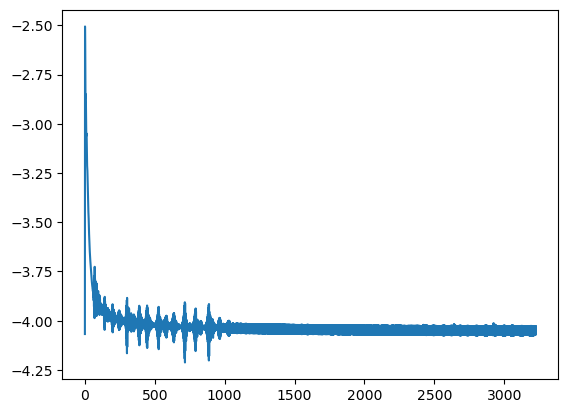

In [26]:

plt.plot(np.log10(history2['mse']))

tensor(0.0022, device='cuda:1') tensor(0.0023, device='cuda:1') tensor(0.0030, device='cuda:1', grad_fn=<MeanBackward0>)


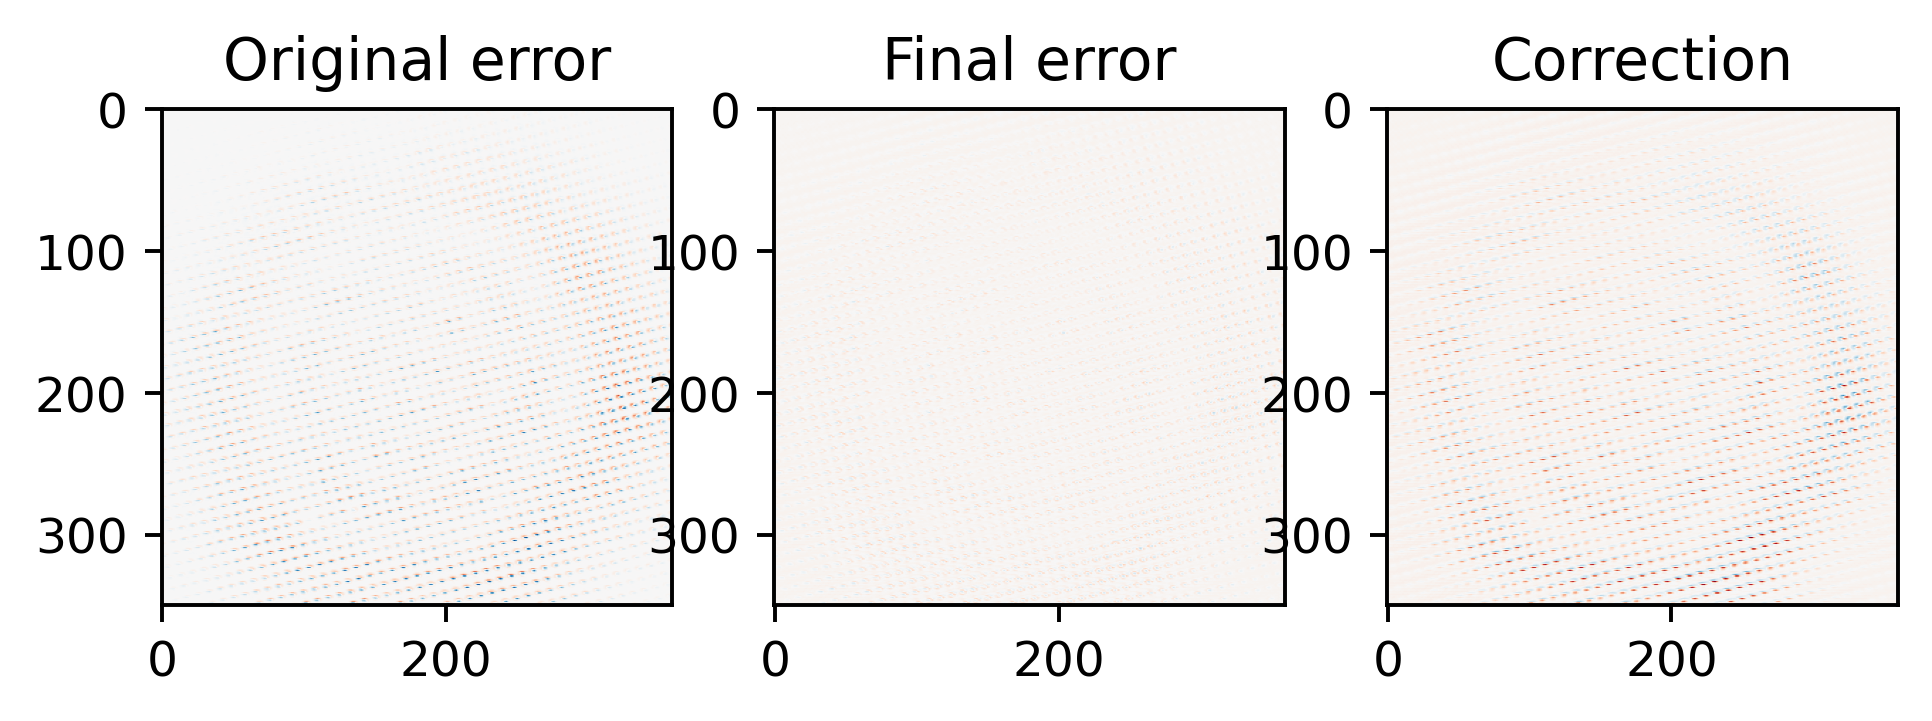

In [27]:
wl = 11

blurred_truth = mask_grating_cube[:,wl].clone()
from scipy.ndimage import gaussian_filter

blurred_truth[0] = torch.ones_like(torch.tensor(gaussian_filter(blurred_truth[0].cpu().detach().numpy(),sigma=20)).to(device))

plot_orig = ((mask_grating_cube[0,wl,] - init_guess_pinhole_slice[0,0])/blurred_truth[0,wl])[150:500,1980:2340]

vmax = plot_orig.abs().max()

fig,ax = plt.subplots(1,3,dpi=350)
a = ax[0].imshow(plot_orig.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax); ax[0].set_title('Original error')
# plt.colorbar(a)
plot_final = ((mask_grating_cube[0,wl,] - yhat[0,0,])/blurred_truth[0,wl])[150:500,1980:2340] #- plot_orig
# vmax = plot_final.abs().max()

b = ax[1].imshow(plot_final.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax); ax[1].set_title('Final error')

plot_diff = (init_guess_pinhole_slice[0,0,150:500,1980:2340] - yhat[0,0,150:500,1980:2340])
vmax = plot_diff.abs().max()
b = ax[2].imshow(plot_diff.cpu().detach().numpy(),cmap = 'RdBu',vmax=vmax,vmin=-vmax);ax[2].set_title('Correction')
# plt.colorbar(b)


print(mask_grating_cube[:,wl].mean(), init_guess_pinhole_slice[:,0].mean(), yhat[:,0].mean())

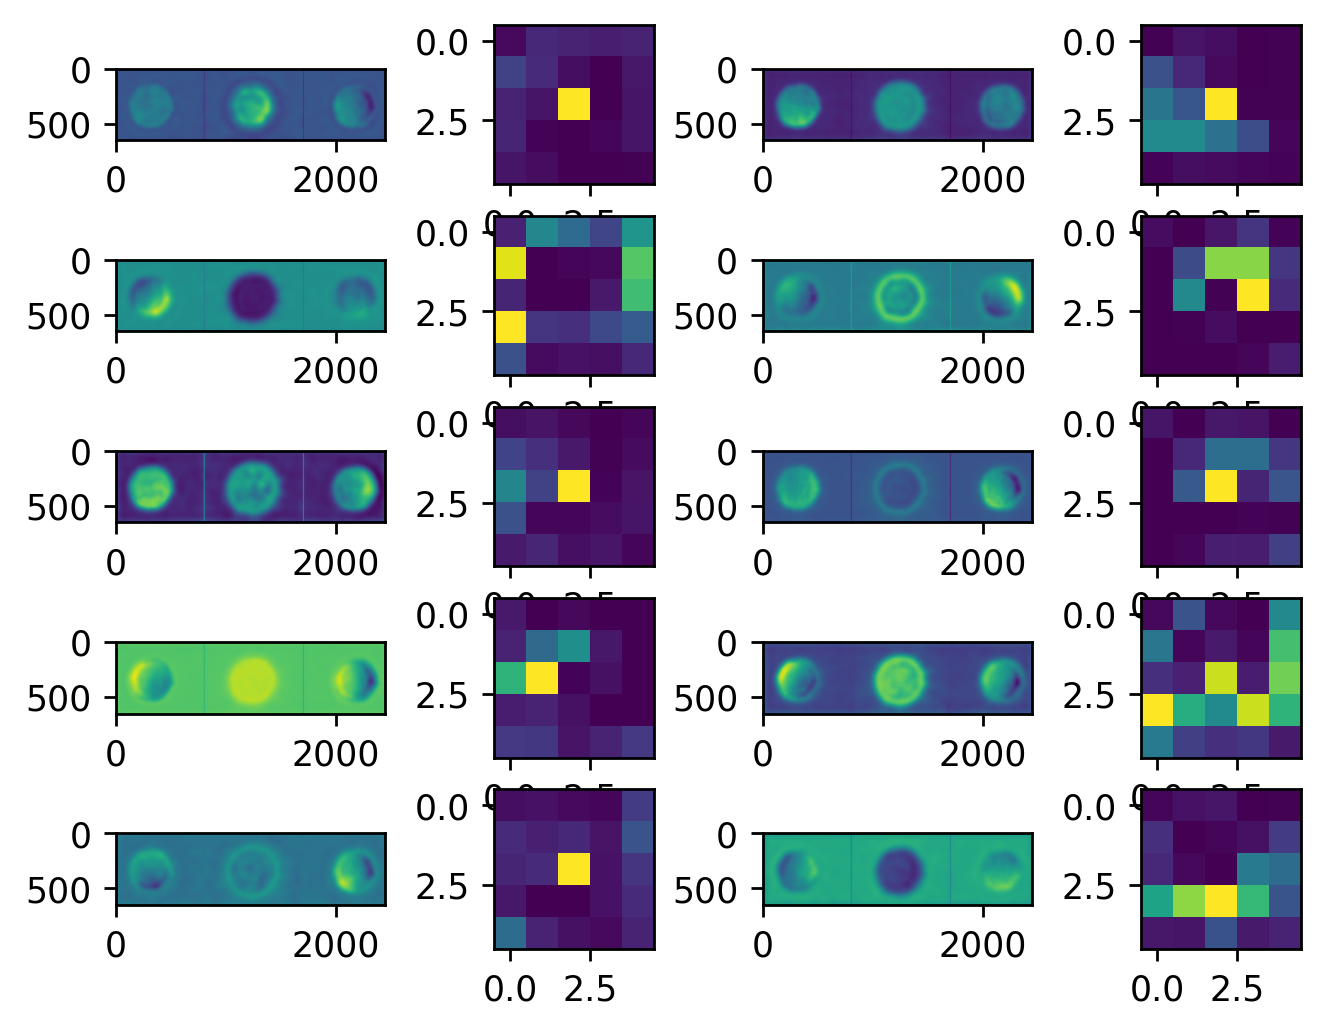

In [29]:
bla = [p for p in CG_conv.parameters()]

fig,ax = plt.subplots(5,4,dpi=250)

for i in range(5):
    ax[i,0].imshow(bla[2].cpu().detach()[0,i*2])
    ax[i,1].imshow(bla[0].cpu().detach()[i*2,0])
    ax[i,2].imshow(bla[2].cpu().detach()[0,i*2+1])
    ax[i,3].imshow(bla[0].cpu().detach()[i*2+1,0])

    # for j in range(2):
    #     ax[i,j].imshow(bla[2].cpu().detach()[0,i*2+j])


In [22]:
for i in range(mask_grating_cube.shape[1]):
    CG_conv_list[i].load_state_dict(CG_conv.state_dict())

In [11]:
yhat = torch.concat([CG_conv_list[i](init_guess_pinhole[:,i:i+1]) for i in range(mask_grating_cube.shape[1])],dim=1)

reg = torch.mean(torch.stack([hessian(torch.nn.functional.relu(CG_conv_list[i].CG.map)) for i in range(mask_grating_cube.shape[1])]))

loss = loss_fn(yhat,mask_grating_cube)

In [12]:
init_reg_factor=1e-5

In [13]:
lr = 4e-3

epochs = 2000

optimizer = torch.optim.Adam(CG_conv_list.parameters(), lr=lr)
# optimizer = torch.optim.Adam(CG_conv.parameters(), lr=lr)

history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []

start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    CG_conv_list.train()
    # CG_conv.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    # yhat = torch.concat([CG_conv(init_guess_pinhole[:,i:i+1]) for i in range(mask_grating_cube.shape[1])],dim=1)
    yhat = torch.concat([CG_conv_list[i](init_guess_pinhole[:,i:i+1]) for i in range(mask_grating_cube.shape[1])],dim=1)

    reg = torch.mean(torch.stack([hessian(torch.nn.functional.relu(CG_conv_list[i].CG.map),boundaries=[800,1700]) for i in range(mask_grating_cube.shape[1])]))
    # reg = hessian(torch.nn.functional.relu(CG_conv.CG.map), boundaries = [800,1700])

    mse = loss_fn(yhat,mask_grating_cube) 
    
    loss = mse + reg * init_reg_factor

    loss.backward()
    optimizer.step()

    for i in range(mask_grating_cube.shape[1]):
        CG_conv_list[i].conv.weight.data = torch.clamp(CG_conv_list[i].conv.weight.data,0,100)
    # CG_conv.conv.weight.data = torch.clamp(CG_conv.conv.weight.data,0,100)


    train_loss         = loss.data.item() * mask_grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},train mse: {mse:5.5g},train reg: {reg*init_reg_factor:5.5g},  epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)

In [19]:
torch.save(CG_conv_list, '../CG_conv_list.pt')

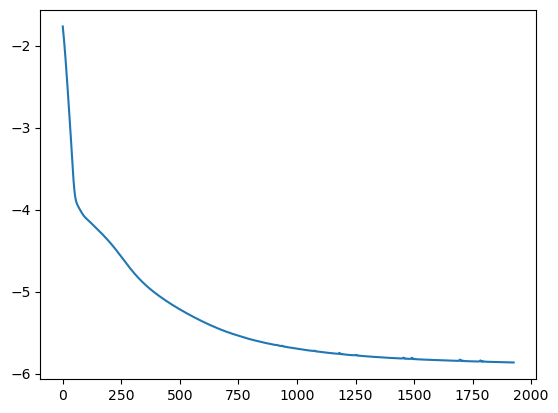

In [16]:
plt.plot(np.log10(history2['mse']))


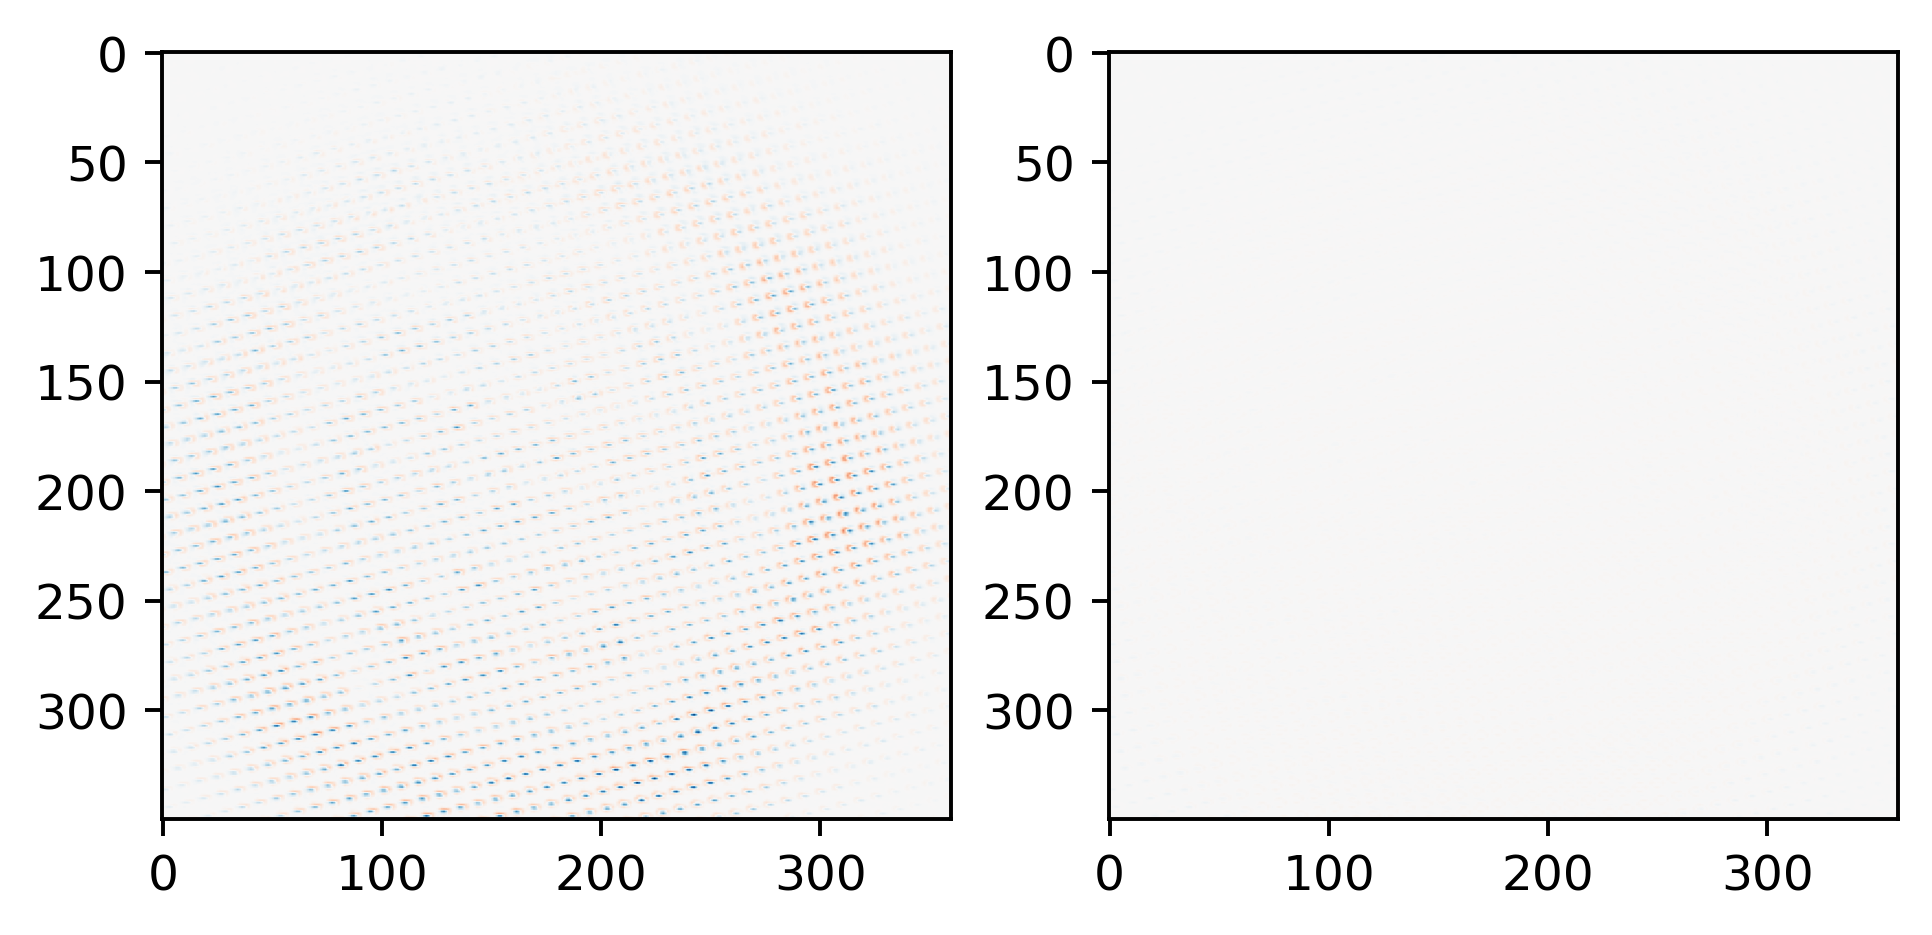

In [17]:
wl = 8

blurred_truth = mask_grating_cube.clone()
from scipy.ndimage import gaussian_filter

blurred_truth[0] = torch.ones_like(torch.tensor(gaussian_filter(blurred_truth[0].cpu().detach().numpy(),sigma=20)).to(device))

plot = ((mask_grating_cube[0,wl,] - init_guess_pinhole[0,wl])/blurred_truth[0,wl])[150:500,1980:2340]

vmax = plot.abs().max()

fig,ax = plt.subplots(1,2,dpi=350)
a = ax[0].imshow(plot.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax)
# plt.colorbar(a)
plot = ((mask_grating_cube[0,wl,] - yhat[0,wl,])/blurred_truth[0,wl])[150:500,1980:2340]
# vmax = plot.abs().max()

ax[1].imshow(plot.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax)
# plt.colorbar()

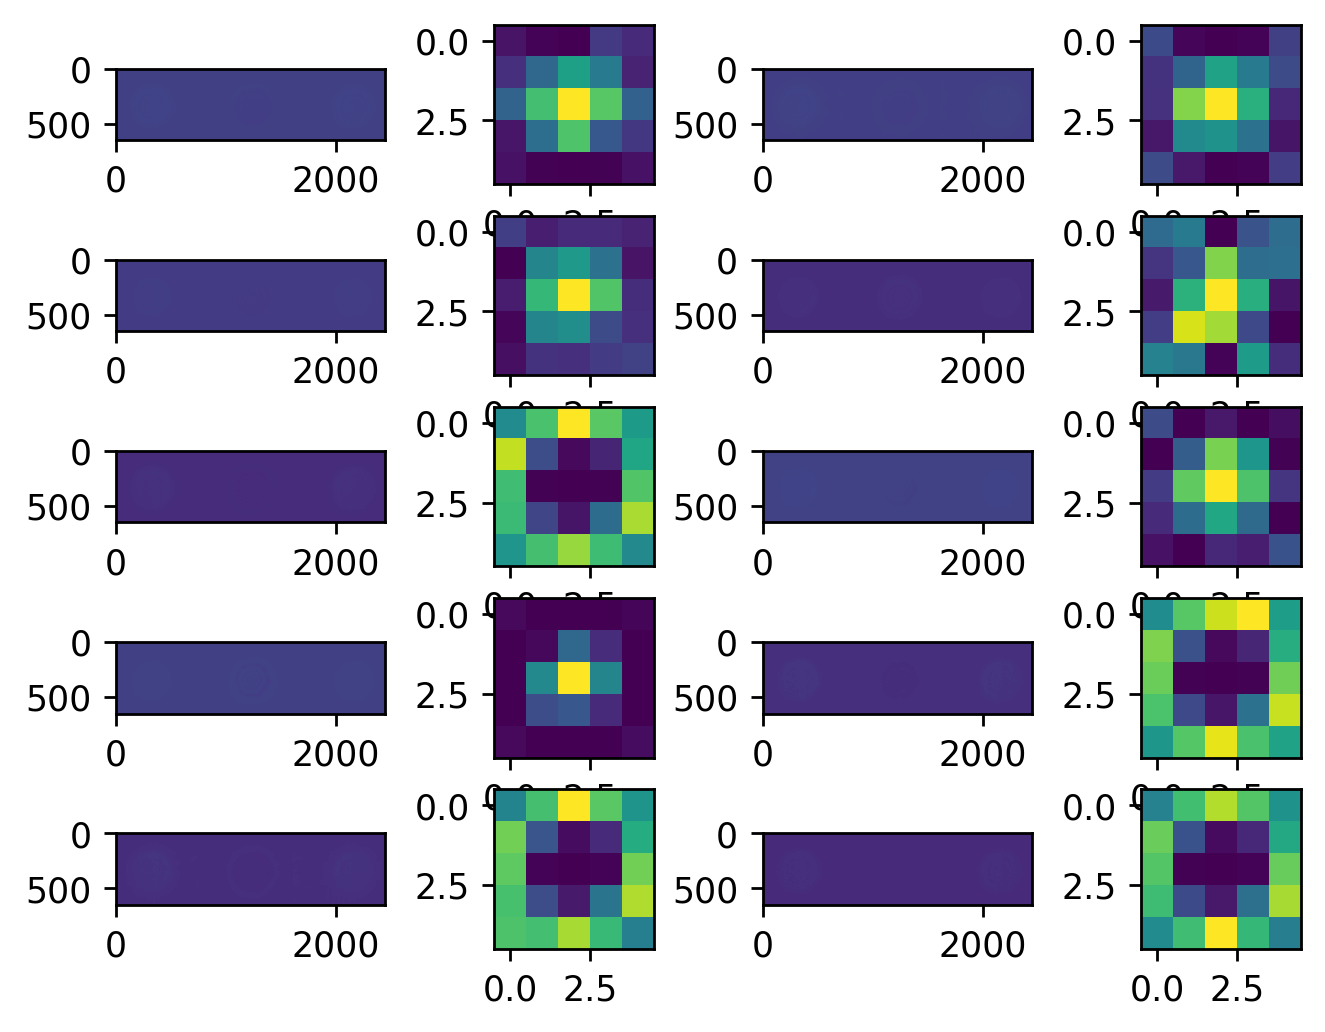

In [19]:
bla = [p for p in CG_conv_list[10].parameters()]

fig,ax = plt.subplots(5,4,dpi=250)

for i in range(5):
    ax[i,0].imshow(bla[2].cpu().detach()[0,i*2])
    ax[i,1].imshow(bla[0].cpu().detach()[i*2,0])
    ax[i,2].imshow(bla[2].cpu().detach()[0,i*2+1])
    ax[i,3].imshow(bla[0].cpu().detach()[i*2+1,0])

In [48]:
padding = 1


fine_model_mask = KernelLearner(kernel=trained_kernel.detach().clone(), padding=padding).to(device) 

lr = 1e-3
epochs = 1300

all_params = list(fine_model_mask.parameters()) + list(CG_conv.parameters())

optimizer = torch.optim.Adam(all_params, lr=lr)

init_guess = fine_model_mask(mask_nograting_cube)
#
loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,mask_grating_cube)
print(loss)

tensor(8.2774e-06, device='cuda:1', grad_fn=<MseLossBackward0>)


In [49]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []

start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    fine_model_mask.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    yhat = fine_model_mask(mask_nograting_cube)
    yhat = torch.concat([CG_conv(yhat[:,i:i+1]) for i in range(mask_grating_cube.shape[1])],dim=1)
    loss = loss_fn(yhat, mask_grating_cube)

    loss.backward()
    optimizer.step()

    train_loss         = loss.data.item() * mask_grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)

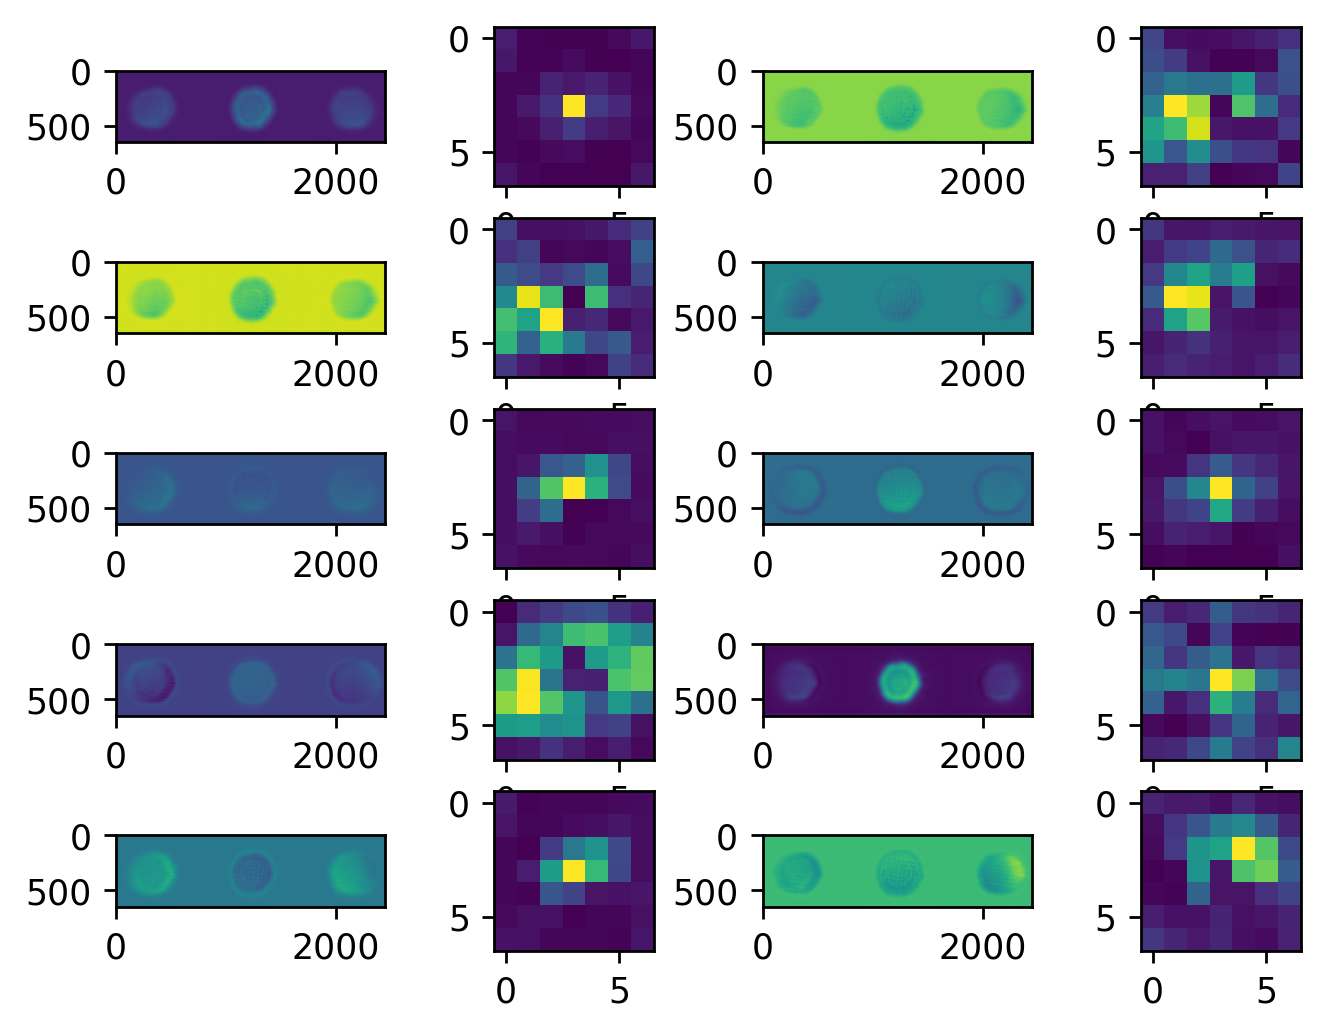

In [52]:
bla = [p for p in CG_conv.parameters()]

fig,ax = plt.subplots(5,4,dpi=250)

for i in range(5):
    ax[i,0].imshow(bla[2].cpu().detach()[0,i*2])
    ax[i,1].imshow(bla[0].cpu().detach()[i*2,0])
    ax[i,2].imshow(bla[2].cpu().detach()[0,i*2+1])
    ax[i,3].imshow(bla[0].cpu().detach()[i*2+1,0])

Text(0.5, 0, 'Epochs')

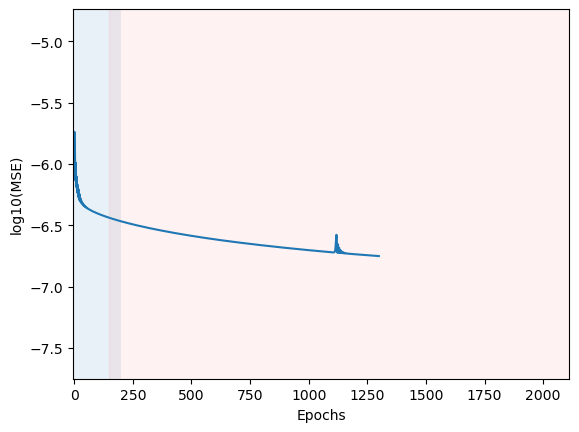

In [50]:
mina, maxa = np.log10(history2['mse']).min(), np.log10(history2['mse']).max()

plt.plot(np.log10(history2['mse']))
# plt.plot(np.log10(history['mse']+history2['mse']))
plt.fill_betweenx(np.linspace(-9,1,100),-1,200,alpha=0.1)
plt.fill_betweenx(np.linspace(-9,1,100),150,2109,color='r',alpha=0.05)

plt.xlim([-5,2110])
plt.ylim([mina-1,maxa+1])
plt.ylabel('log10(MSE)')
plt.xlabel('Epochs')

In [21]:
trained_kernel = fine_model_mask.fill_kernel()
torch.save(trained_kernel, '../kernel_mono_mask.pt')

In [51]:
print(loss_fn(fine_model_mask(nograting_cube), grating_cube))
print(loss_fn(fine_model_mask(mask_nograting_cube), mask_grating_cube))
print(loss_fn(fine_model_mask(lines_nograting_cube), lines_grating_cube))

tensor(1.6460e-09, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(1.8693e-06, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(9.0560e-07, device='cuda:1', grad_fn=<MseLossBackward0>)


In [23]:
trained_kernel = torch.load('../kernel_mono_mask.pt',map_location=device).requires_grad_(False)

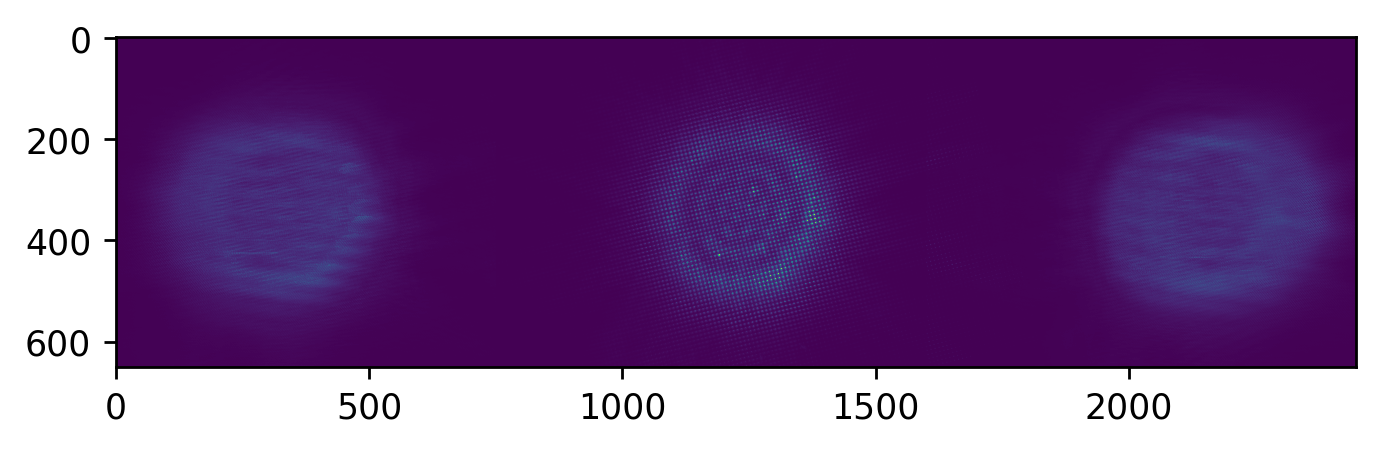

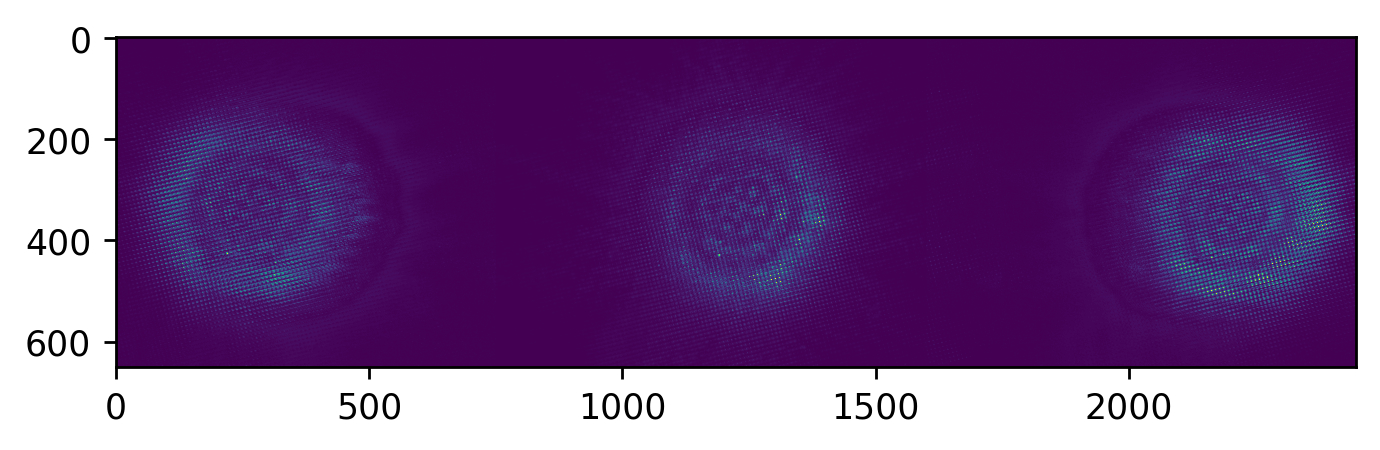

In [55]:
plt.figure(dpi=250)
plt.imshow((mask_grating_cube[0,:,] - yhat[0,:,]).abs().sum(0).cpu().detach().numpy(),vmax = mask_grating_cube[0,:,].sum(0).max() * 0.01)

wl = 21

plt.figure(dpi=250)
plt.imshow((mask_grating_cube[0,wl,] - yhat[0,wl,]).abs().cpu().detach().numpy(),vmax= mask_grating_cube[0,wl,].max()*0.01)

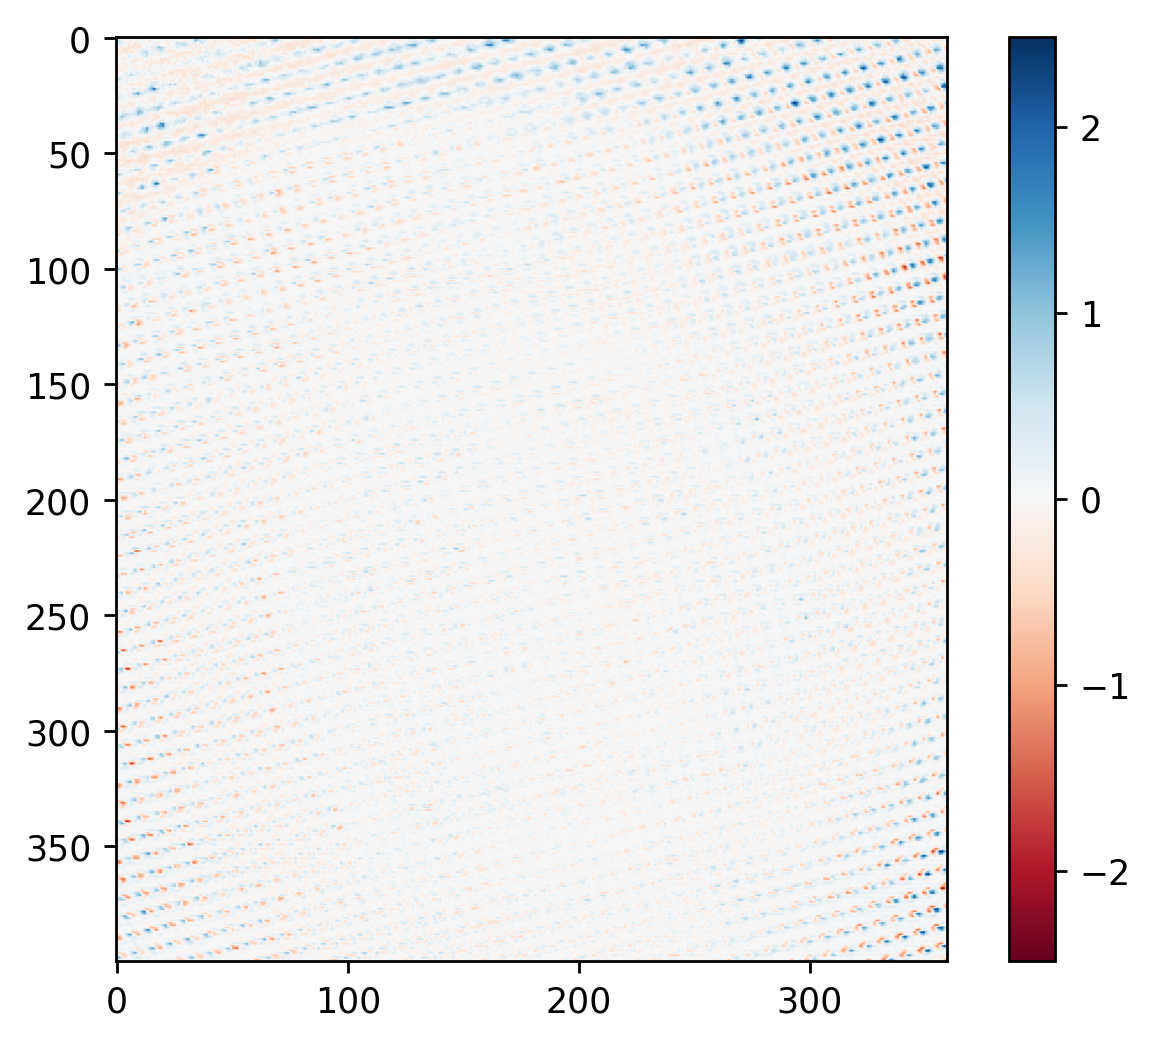

In [57]:
wl = 11

blurred_truth = mask_grating_cube.clone()
from scipy.ndimage import gaussian_filter

blurred_truth[0,wl] = torch.tensor(gaussian_filter(blurred_truth[0,wl].cpu().detach().numpy(),sigma=20)).to(device)

plot = ((mask_grating_cube[0,wl,] - yhat[0,wl,])/blurred_truth[0,wl])[100:500,1980:2340]

vmax = plot.abs().max()

plt.figure(dpi=250)
plt.imshow(plot.cpu().detach().numpy(),cmap = 'RdBu',vmax = vmax, vmin = -vmax)
plt.colorbar()

In [77]:
yhat_inv = fwd.disperser.undisperse_all_orders( mask_grating_cube,trained_kernel)

In [78]:
loss_fn(yhat_inv,mask_nograting_cube) 

tensor(1.6145e-06, device='cuda:1', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

### train it on the inverses too

In [79]:
kernel = torch.load('../kernel_mono_mask.pt',map_location=device).requires_grad_(False)

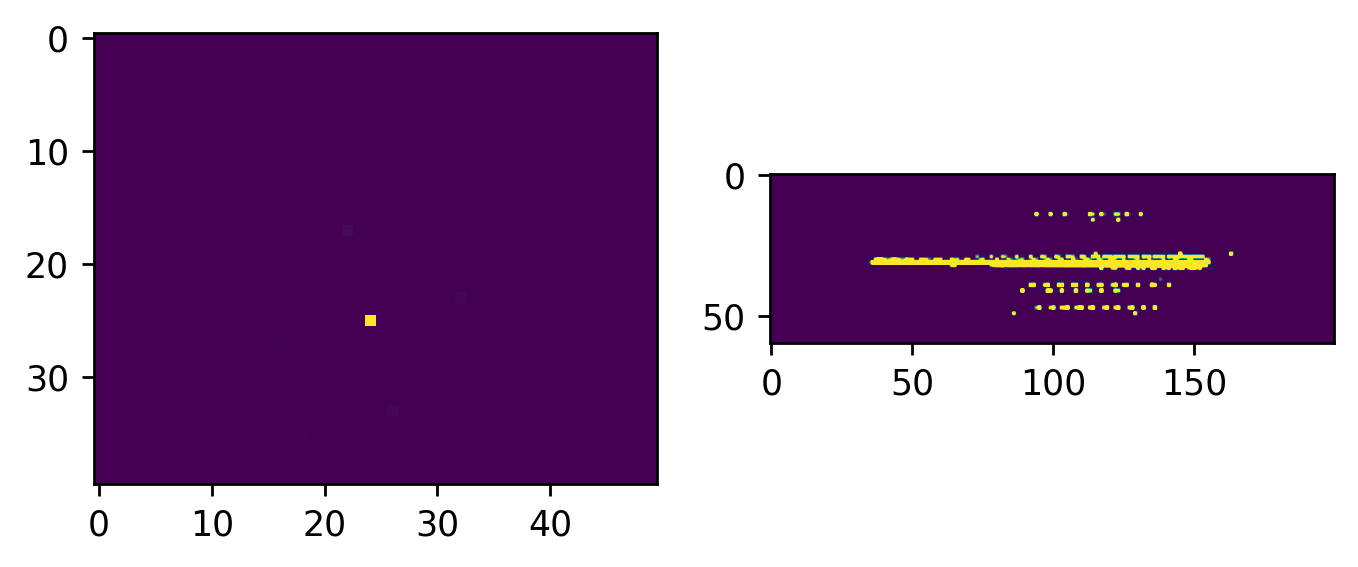

In [83]:
fig,ax = plt.subplots(1,2,dpi=250)
ax[0].imshow(kernel.sum((0,1))[300:340,1200:1250].cpu().detach(),vmax=5)
ax[1].imshow(kernel.sum((0,1))[290:350,200:400].cpu().detach(),vmax=0.001)

In [5]:
padding = 10


fine_model_all = KernelLearner(kernel=kernel.detach().clone(), padding=padding).to(device) 

lr = 4e-6
epochs = 1300

optimizer = torch.optim.Adam(fine_model_all.parameters(), lr=lr)

init_guess = fine_model_all(mask_nograting_cube)
#
loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,mask_grating_cube)
print(loss)

tensor(6.8879e-07, device='cuda:1', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


In [7]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []
history2['forward'] = []
history2['inverse'] = []

start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    fine_model_all.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    yhat = fine_model_all(mask_nograting_cube)
    yhat_p = fine_model_all(nograting_cube)

    yhat_inv = fine_model_all.forward_inverse(mask_grating_cube)
    yhat_p_inv = fine_model_all.forward_inverse(grating_cube)

    loss_forward = loss_fn(yhat, mask_grating_cube)
    loss_inverse = loss_fn(yhat_inv, mask_nograting_cube)
    loss_forward_p = loss_fn(yhat_p, grating_cube)
    loss_inverse_p = loss_fn(yhat_p_inv, nograting_cube)

    loss = loss_forward + loss_inverse + loss_forward_p + loss_inverse_p

    loss.backward()
    optimizer.step()

    train_loss         = loss.data.item() * mask_grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, lossforward: {loss_forward.data.item():5.5g}, lossinverse: {loss_inverse:5.5g},lossforwardp: {loss_forward_p.data.item():5.5g}, lossinversep: {loss_inverse_p:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)
    history2['forward'].append(loss_forward.data.item())
    history2['inverse'].append(loss_inverse.data.item())

KeyboardInterrupt: 

In [8]:
fine_model_all.lamb

Parameter containing:
tensor([0.0002], device='cuda:1', requires_grad=True)

In [9]:
trained_kernel = fine_model_all.fill_kernel()
torch.save(trained_kernel, '../kernel_mono_inv.pt')


In [10]:
del kernel

In [12]:
torch.cuda.empty_cache()

In [13]:
mask_pred = fwd.disperser.undisperse_all_orders( mask_grating_cube,trained_kernel)

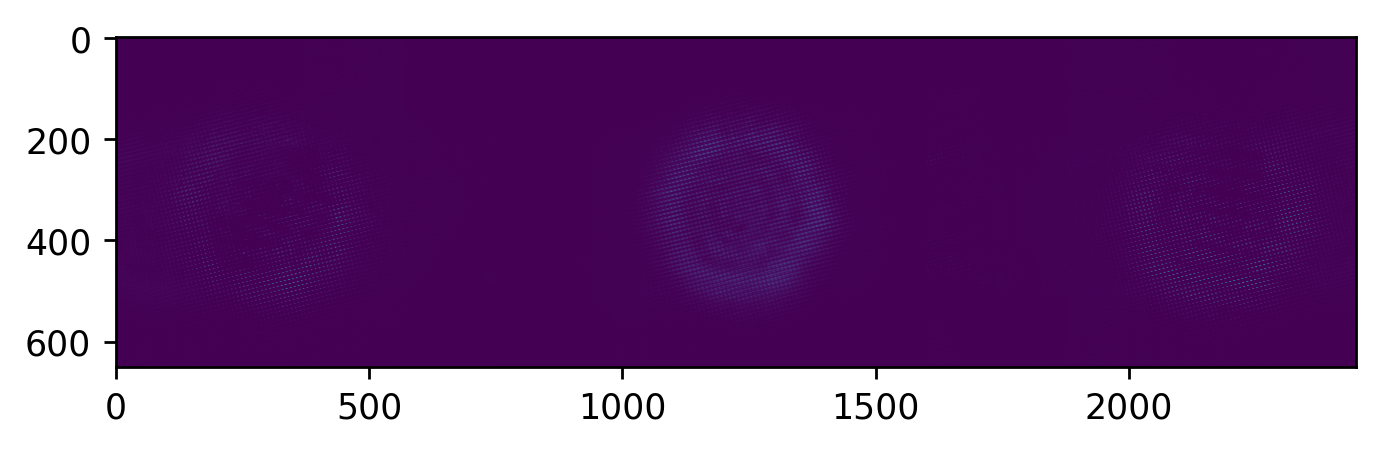

In [14]:
fig,ax = plt.subplots(1,1,dpi=250)
ax.imshow((mask_pred[0,14].detach().cpu() - mask_nograting_cube[0,14].detach().cpu()).abs(), vmax = mask_nograting_cube[0,14].detach().cpu().max() * 0.05)

In [15]:
lines_pred = fwd.disperser.undisperse_all_orders( lines_grating_cube,trained_kernel)
lines_grating_pred = fwd.disperser.disperse_all_orders( lines_nograting_cube,trained_kernel)

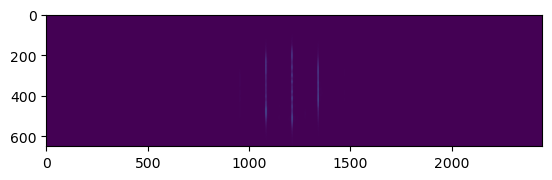

In [19]:
plt.imshow(lines_pred.sum((0,1)).cpu().detach())

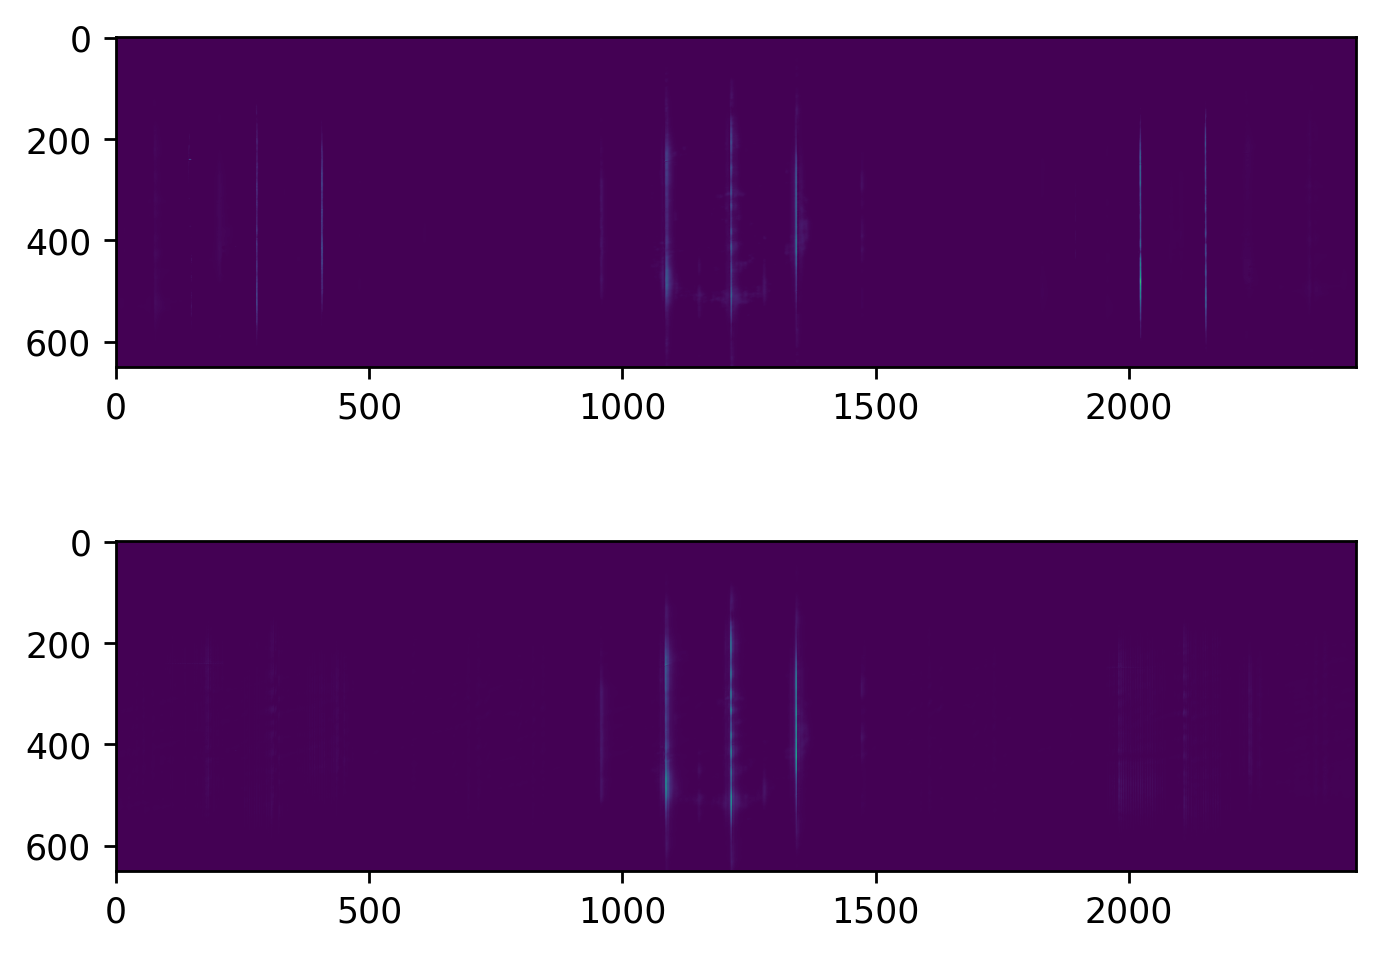

In [26]:
fig,ax = plt.subplots(2,1,dpi=250)
ax[0].imshow((lines_pred[0,14].detach().cpu() - lines_nograting_cube[0,14].detach().cpu()).abs(), vmax = lines_nograting_cube[0,14].detach().cpu().max() * 0.1)
ax[1].imshow((lines_pred[0,:].detach().cpu() - lines_nograting_cube[0,:].detach().cpu()).abs().sum(0), vmax = lines_nograting_cube[0,:].sum(0).detach().cpu().max() * 0.1)

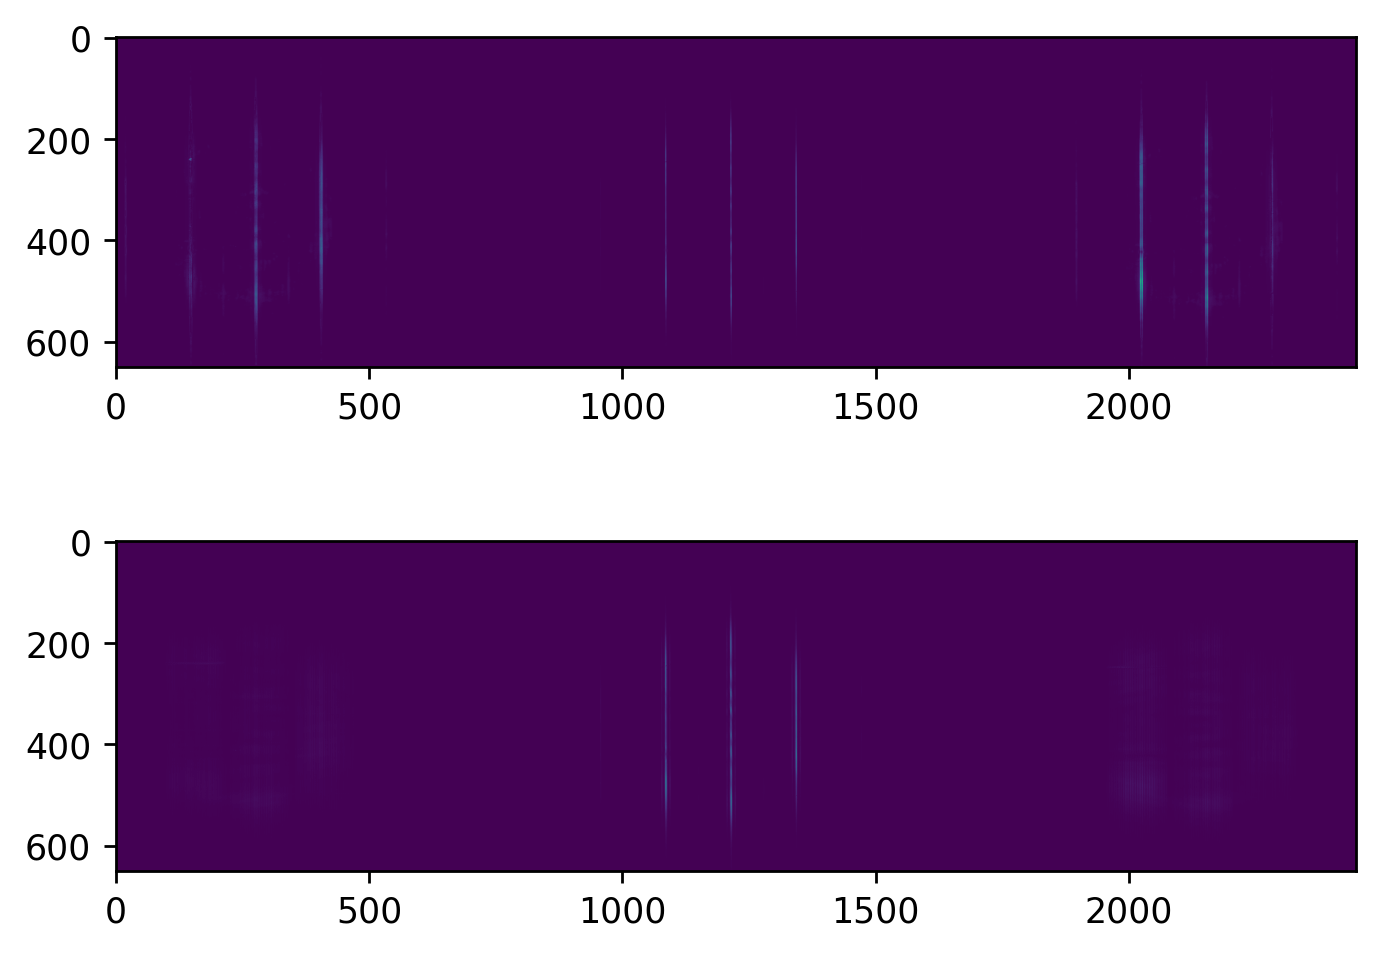

In [29]:
fig,ax = plt.subplots(2,1,dpi=250)
ax[0].imshow((lines_grating_pred[0,14].detach().cpu() - lines_grating_cube[0,14].detach().cpu()).abs(), vmax = lines_grating_cube[0,14].detach().cpu().max() * 0.1)
ax[1].imshow((lines_grating_pred[0,:].detach().cpu() - lines_grating_cube[0,:].detach().cpu()).abs().sum(0), vmax = lines_grating_cube[0,:].sum(0).detach().cpu().max() * 0.1)

In [7]:
trained_kernel = torch.load('../kernel_mono_all.pt',map_location=device).requires_grad_(False)

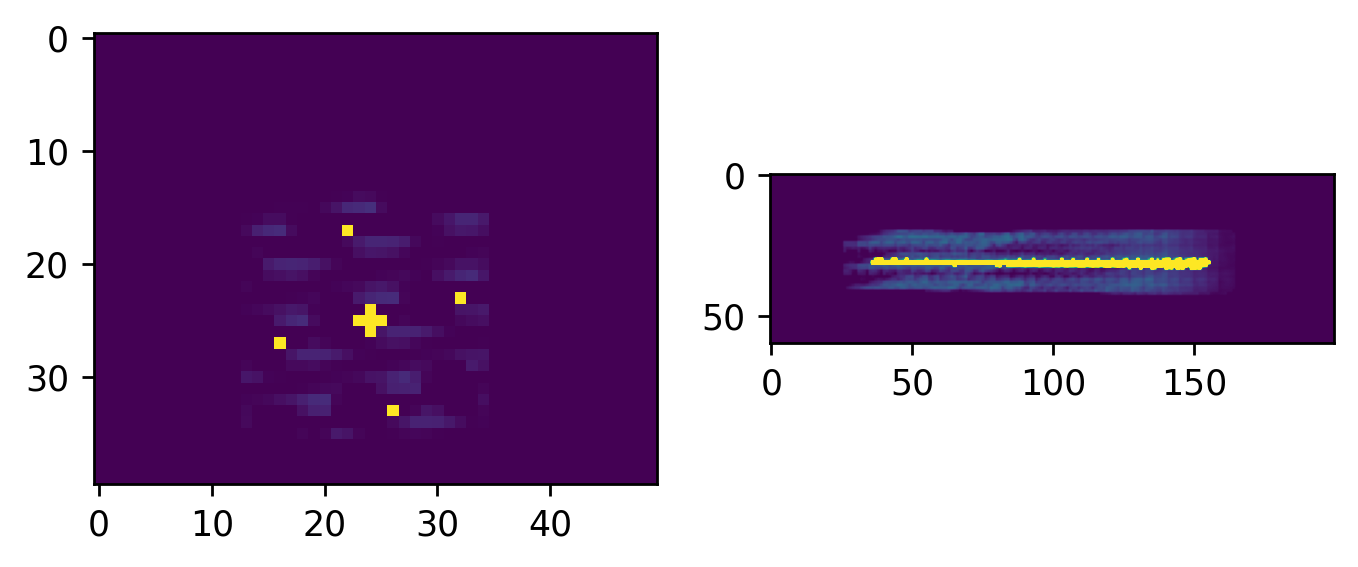

In [8]:
fig,ax = plt.subplots(1,2,dpi=250)
ax[0].imshow(trained_kernel.sum((0,1))[300:340,1200:1250].cpu().detach(),vmax=0.01)
ax[1].imshow(trained_kernel.sum((0,1))[290:350,200:400].cpu().detach(),vmax=0.001)